In [1]:
import argparse
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset_builder, load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader
import os
import json
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import random
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import time
import difflib


from finetune import CloneDetector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Functions

In [2]:
def find_threshold(scores, labels, metric='f1'):
    # metric: 'acc' or 'f1'

    for label in labels:
        assert abs(label - 1) < 1e-10 or abs(label) < 1e-10
    assert metric in ['acc', 'f1']

    arr = sorted(list(zip(scores, labels)), key=lambda x: x[0])

    pre = 0.0
    post = sum(labels)

    max_eval, best_threshold = 0.0, arr[0][0]
    for i in range(len(arr) - 1):
        pre += arr[i][1]
        post -= arr[i][1]

        tp = post
        fp = len(arr) - i - post
        fn = pre
        tn = (i-pre)

        acc = (tp + tn) / len(arr)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

        eval = {'acc': acc, 'f1': f1}

        if max_eval < eval[metric]:
            max_eval = acc
            best_threshold = (arr[i][0] + arr[i][1]) / 2
    return best_threshold

def accuracy(scores, labels, threshold):
    return np.mean(((scores > threshold).astype(np.int32) == labels).astype(np.float32)).tolist()


def f1_score(scores, labels, threshold):
    return metrics.f1_score((scores > threshold), labels)

def sumCounter(counter):
    return sum(counter.values())

    
class AugmentedDataset(Dataset):
    def __init__(self, inputs):
        self.data = inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


# Load Model

In [3]:

model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer('print("hello")'))
print(tokenizer('print("hello")\n'))
print(tokenizer('print("hello")  '))

{'input_ids': [0, 17265, 46469, 42891, 8070, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 17265, 46469, 42891, 8070, 50118, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 17265, 46469, 42891, 8070, 1437, 1437, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [4]:
%%time


model_name = "Salesforce/codet5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer('print("hello")'))
print(tokenizer('print("hello")\n'))
print(tokenizer('print("hello")  '))

{'input_ids': [1, 1188, 2932, 23711, 7923, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'input_ids': [1, 1188, 2932, 23711, 7923, 203, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [1, 1188, 2932, 23711, 7923, 282, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
CPU times: user 116 ms, sys: 15.9 ms, total: 132 ms
Wall time: 226 ms


In [5]:
batch_size = 8

def tokenize(code):
    return tokenizer(code, return_tensors="pt", truncation=True, padding="longest", max_length=512)

def collate_fn(items):
    x = {}

    code1, code2, labels = [], [], []
    for item in items:
        code1.append(item['code1'])
        code2.append(item['code2'])
        labels.append(item['similar'])

    x['code1'] = tokenize(code1)
    x['code2'] = tokenize(code2)
    x['labels'] = torch.tensor(labels, dtype=torch.float32)

    return x

ckpt_path = '/mnt/hdd/696ds/tasks/clone_detection/codebert/ckpt/0512_codet5-base_lr1.0e-05-w5000/step400000.pt'
# model = CloneDetector(model_name, device)
model = torch.load(ckpt_path).to(device)
model.device = device
model.train(False)

CloneDetector(
  (model): T5EncoderModel(
    (shared): Embedding(32100, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32100, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_features=3072, ou

# Find threshold using val data from a different fold (fold 5/5)

In [6]:
%%time
batch_size = 8
n_th = 30000

dataset = load_from_disk("/mnt/hdd/696ds_data/PoolC/original/1-fold-clone-detection-600k-5fold")["val"]
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

CPU times: user 121 ms, sys: 470 ms, total: 590 ms
Wall time: 3.34 s


In [7]:
%%time
scores_list, labels_list = [], []
pbar = tqdm(dataloader, total=(n_th+batch_size-1) // batch_size)
for i, batch in enumerate(pbar):
        
    if batch_size * i >= n_th:
        break
    
    labels = batch['labels']
    
    scores = model(batch).to('cpu')
    
    scores, labels = scores.tolist(), labels.tolist()
    
    scores_list += scores if type(scores) == list else [scores]
    labels_list += labels if type(labels) == list else [labels]
    
scores, labels = np.array(scores_list), np.array(labels_list)
threshold = find_threshold(scores, labels)
acc, f1 = accuracy(scores, labels, threshold), f1_score(scores, labels, threshold)
print(threshold)

  0%|          | 0/3750 [00:00<?, ?it/s]

0.6826467514038086
CPU times: user 6min 32s, sys: 25.1 s, total: 6min 57s
Wall time: 5min 11s


In [8]:
# threshold = 0.5012134909629822

# Read Augmented Dataset

In [9]:
%%time
save_dir = "/mnt/ssd/696ds_data/PoolC/1-fold-clone-detection-600k-5fold/val/050123/"
print(os.listdir(save_dir))
save_path = os.path.join(save_dir, "augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_group.json")

# p2index = {"0.5": 0}

with open(save_path, 'r') as f:
    json_data = json.load(f)
    print(type(json_data))
    
data = json_data['data']



['augmented__p0.1_p0.2_p0.3_p0.4_p0.5_p0.6_p0.7_p0.8_p0.9_p1.0_group.json']
<class 'dict'>
CPU times: user 14.7 s, sys: 2.89 s, total: 17.5 s
Wall time: 17.4 s


In [10]:
print(data[0]['augmented'][0].keys())

dict_keys(['code1', 'code1_log', 'code2', 'code2_log'])


In [11]:
print(data[0]['augmented'][0]['code1_log'].keys())

dict_keys(['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports'])


In [12]:
print(data[0]['augmented'][0]['code1'].keys())

dict_keys(['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports'])


# Evaluate on the PoolC dataset

In [13]:
def func(datapoints):
        
    dataset = AugmentedDataset(datapoints)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    scores_list = []
    labels_list = []
    for j, batch in enumerate(dataloader):

        labels = batch['labels']
        scores = model(batch).to('cpu')

        labels, scores = labels.tolist(), scores.tolist()
        labels_list += labels if type(labels) == list else [labels]
        scores_list += scores if type(scores) == list else [scores]


    scores = np.array(scores_list)
    labels = np.array(labels_list)
    return np.array(scores_list), np.array(labels_list)

def original_scores(n):
    dataset1 = []
    for i in range(len(data)):
        if len(dataset1) == n:
            break
            
        dataset1.append(
            {
                'code1': data[i]['original']['code1'],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )

    scores1, labels1 = func(dataset1)
    acc1 = accuracy(scores1, labels1, threshold)
    f1_1 = f1_score(scores1, labels1, threshold)
    
    
    results = {
        'Accuracy': acc1,
        'F1': f1_1,
        'Mean': np.mean(scores1),
        'Standard Deviation': np.std(scores1),
        'Same Prediction': 1.0,
        'Mean Absolute Difference': 0.0,
#         'Standard Deviation of Absolute Difference': 0.0,
#         'Root Mean Squared Difference': 0.0
        
    }
    
    return scores1, results
    

def augmented_scores(p, transformation_type, n, scores1):
    index = p2index[p]
    logs = Counter()
    dataset2 = []
    for i in range(len(data)):
        if len(dataset2) == n:
            break
            
        dataset2.append(
            {
                'code1': data[i]['augmented'][p2index[p]]['code1'][transformation_type],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )
        
        for key, value in data[i]['augmented'][p2index[p]]['code1_log'][transformation_type].items():
            logs[key] += value
            
    scores, labels = func(dataset2)

    acc = accuracy(scores, labels, threshold)
    f1 = f1_score(scores, labels, threshold)
    mean_absolute_difference = np.mean(np.abs(scores1-scores))
    
    results = {
        'Accuracy': acc,
        'F1': f1,
        'Mean': np.mean(scores),
        'Standard Deviation': np.std(scores),
        'Same Prediction': np.mean((scores1 > threshold) == (scores > threshold)),
        'Mean Absolute Difference': mean_absolute_difference,
#         'Standard Deviation of Absolute Difference': np.std(abs(scores1-scores) - mean_absolute_difference),
#         'Root Mean Squared Difference': np.sqrt(np.mean((scores1 - scores) ** 2))
    }
    
    diffs = [(i, original_pred) for i, (original_pred, same) in enumerate(zip(scores1 > threshold, (scores1 > threshold) == (scores > threshold))) if not same]

    
#     print('p:', p)
#     for key, value in results.items():
#         print(f"{key:<30}: {value:>3.3f}")
#     print()
    return results, logs, diffs, scores


In [14]:
%%time
n_pc = 30000

scores1, results1 = original_scores(n_pc)


CPU times: user 6min 13s, sys: 22.3 s, total: 6min 36s
Wall time: 4min 57s


In [15]:
print(results1)

{'Accuracy': 0.7676576375961304, 'F1': 0.7904361833170146, 'Mean': 0.8105140998102706, 'Standard Deviation': 1.3810542730135433, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}


In [16]:
p2index = {f'0.{i+1}': i for i in range(9)}
p2index['1.0'] = 9
transformation_types = list(data[0]['augmented'][0]['code1_log'].keys())

In [17]:
%%time
targets = sorted(list(p2index.keys()), key=lambda x:float(x))
# targets = ['0.2', '0.5', '0.7', '1.0']
results = defaultdict(dict)
logs = defaultdict(dict)
diffs = defaultdict(dict)
scores = defaultdict(dict)
for transformation_type in transformation_types:
    results[transformation_type]['0.0'] = results1
    logs[transformation_type]['0.0'] = Counter()
    scores[transformation_type]['0.0'] = scores1
    for p in targets:
        results[transformation_type][p], logs[transformation_type][p], diffs[transformation_type][p], scores[transformation_type][p] = \
                    augmented_scores(p, transformation_type, n_pc, scores1)

CPU times: user 7h 18min 2s, sys: 26min, total: 7h 44min 2s
Wall time: 5h 48min 29s


In [18]:

targets = ["0.0"] + targets
x = [float(target) for target in targets]


In [19]:
print(transformation_types)

labels = {
    'add_whitespace,add_new_lines,add_commas': 'add whitespaces, new lines, commas',
    'list_comp_to_for,set_comp_to_for,dict_comp_to_for': 'comprehension to for loop',
    'change_variable_names': 'change local variable names',
    'for_to_while,lambda_to_function,combine_statement': 'for loop to while loop, lambda to function, combine statement',
    'remove_comments': 'remove comments',
    'remove_empty_line,remove_whitespace,remove_commas': 'remove empty lines, whitespaces, commas',
    'remove_unused_imports': 'remove unused imports'
}

['add_whitespace,add_new_lines,add_commas', 'list_comp_to_for,set_comp_to_for,dict_comp_to_for', 'change_variable_names', 'for_to_while,lambda_to_function,combine_statement', 'remove_comments', 'remove_empty_line,remove_whitespace,remove_commas', 'remove_unused_imports']


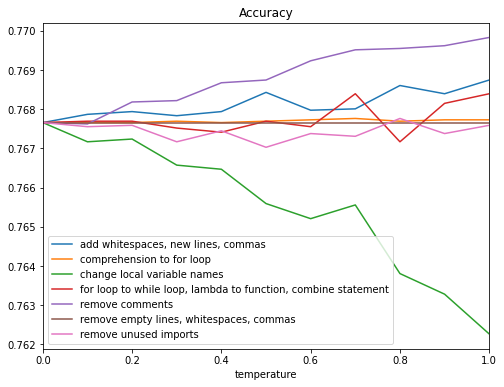

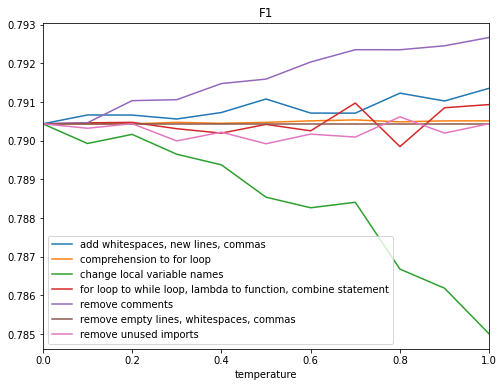

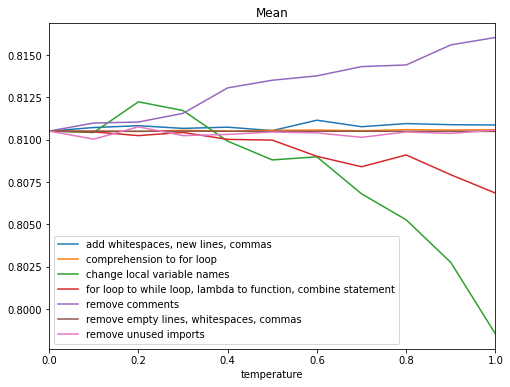

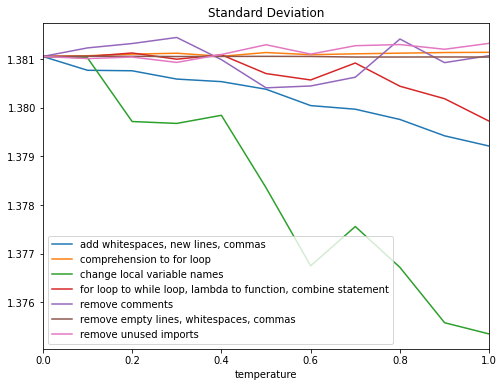

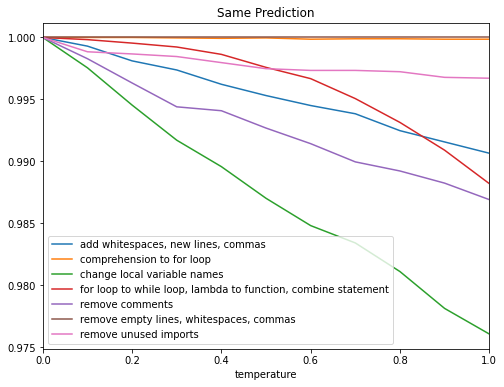

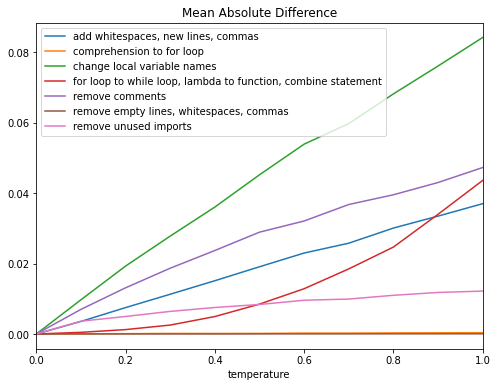

In [20]:
metrics_list = ['Accuracy', 'F1', 'Mean', 'Standard Deviation', 'Same Prediction', 
                'Mean Absolute Difference']
# cm = plt.get_cmap('gist_rainbow')

for metric in metrics_list:
    plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
    for i, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])

    plt.title(metric)
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
    plt.show()

# Print results

In [21]:

for p in targets:
    print(f'======================== [p = {p}] ================================')
    for key in logs.keys():
        print(logs[key][p])
        print(sum(logs[key][p].values()))
        print(results[key][p])
        print()

======================== [p = 0.0] ================================
Counter()
0
{'Accuracy': 0.7676576375961304, 'F1': 0.7904361833170146, 'Mean': 0.8105140998102706, 'Standard Deviation': 1.3810542730135433, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.7676576375961304, 'F1': 0.7904361833170146, 'Mean': 0.8105140998102706, 'Standard Deviation': 1.3810542730135433, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.7676576375961304, 'F1': 0.7904361833170146, 'Mean': 0.8105140998102706, 'Standard Deviation': 1.3810542730135433, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.7676576375961304, 'F1': 0.7904361833170146, 'Mean': 0.8105140998102706, 'Standard Deviation': 1.3810542730135433, 'Same Prediction': 1.0, 'Mean Absolute Difference': 0.0}

Counter()
0
{'Accuracy': 0.7676576375961304, 'F1': 0.7904361833170146, 'Mean': 0.8105140998102706, 'Standard Deviation': 1.3810542730135

# Print cases when the predictions are changed

In [43]:
import pandas as pd
_df = []
for p in targets[1:]:
    print(f'############################## [p = {p}] #####################################')
    for key in diffs.keys():
        print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
        item = diffs[key][p]
        size = len(diffs[key][p])
        
        count = 0
        for i in range(size):
            index = item[i][0]
            code1 = data[index]['original']['code1']
            code1_augmented = data[index]['augmented'][p2index[p]]['code1'][key]
            similar = data[index]['original']['similar']
            code2 = data[index]['original']['code2']
            original_pred = item[i][1]
            
            if (len(code1.split('\n')) + len(code2.split('\n')) > 20):
                continue
                
            if not similar:
                continue
            
            print('==================================================================')
            print(f"p={p}, key={key}")
            print('------------------------------------------------------------------')
            print(
                "".join(
                    difflib.unified_diff(code1.splitlines(1), code1_augmented.splitlines(1))
                )
            )
            print('------------------------------------------------------------------')
            print(code1)
            print('------------------------------------------------------------------')
            print(code1_augmented)
            print('------------------------------------------------------------------')
            print(code2)
            print('------------------------------------------------------------------')
            print(f'similar (original): {similar}, pred(original): {original_pred}')
            print(f'original: {scores[key]["0.0"][index]}, transformed: {scores[key][p][index]}')
            print('==================================================================')
            
            count += 1
#             if count == 3:
#                 break
            
            _df.append(
                {
                    'p': p,
                    'transformation_type': key,
                    'code1': code1,
                    'code1_augmented': code1_augmented,
                    'similar': similar,
                    'code2': code2,
                    'original_pred': original_pred,
                    'index': index,
                    'score_original': scores[transformation_type]["0.0"][index],
                    'score_transformed': scores[key][p][index]
                }
            )
            
#             print_code_diff(f"p={p}, key={key}", original, augmented, code2, similar, show_diff=True)
            
            time.sleep(0.5)
df = pd.DataFrame(_df)
print(df)
df.to_csv('0524_CodeT5_results.csv')


# 0.6826467514038086

############################## [p = 0.1] #####################################
%%%%%%%%%%%%%%%%%%%%%% [key = add_whitespace,add_new_lines,add_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.1, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1 +1 @@
-print(sum(s!=t for s,t in zip(*open(0))))+print(sum(s!=t for s,t, in zip(*open(0))))
------------------------------------------------------------------
print(sum(s!=t for s,t in zip(*open(0))))
------------------------------------------------------------------
print(sum(s!=t for s,t, in zip(*open(0))))
------------------------------------------------------------------
import re
S = input()
T = input()
result=0
if(len(S)!=len(T)):
    pass
elif(re.fullmatch(r'[a-z]{1,200000}', S) and re.fullmatch(r'[a-z]{1,200000}', T)):
    for i in range(len(S)):
        if S[i]!=T[i]:
            result+=1
    print(result)
----------------------------------------------------------------

############################## [p = 0.2] #####################################
%%%%%%%%%%%%%%%%%%%%%% [key = add_whitespace,add_new_lines,add_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.2, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-N,*X = map(int, open(0).read().split())
+N,*X, = map(int, open(0).read().split())
 ans = float('inf')
 for i in range(1,max(X)+1):
     temp = 0

------------------------------------------------------------------
N,*X = map(int, open(0).read().split())
ans = float('inf')
for i in range(1,max(X)+1):
    temp = 0
    for j in range(N):
        temp += (X[j]-i) ** 2
    ans = min(ans,temp)
print(ans)
------------------------------------------------------------------
N,*X, = map(int, open(0).read().split())
ans = float('inf')
for i in range(1,max(X)+1):
    temp = 0
    for j in range(N):
        temp += (X[j]-i) ** 2
    ans = min(ans,temp)
print(ans)
--------------------

p=0.2, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -2,10 +2,10 @@
     import sys
     input = lambda: sys.stdin.readline().rstrip()
 
-    h1, m1, h2, m2, k = map(int, input().split())
+    v0, v1, h2, m2, k = map(int, input().split())
 
-    m = 60 - m1
-    h1 += 1
-    m += (h2 - h1)*60 + m2
+    m = 60 - v1
+    v0 += 1
+    m += (h2 - v0)*60 + m2
     print(max(0, m - k))
 main()
------------------------------------------------------------------
def main():
    import sys
    input = lambda: sys.stdin.readline().rstrip()

    h1, m1, h2, m2, k = map(int, input().split())

    m = 60 - m1
    h1 += 1
    m += (h2 - h1)*60 + m2
    print(max(0, m - k))
main()
------------------------------------------------------------------
def main():
    import sys
    input = lambda: sys.stdin.readline().rstrip()

    v0, v1, h2, m2, k = map(int, input().split())

    m = 60 - v1
    v0 += 1
    m += (h2 - v0)*60 + m2
    print(max(0

p=0.2, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 X=int(input())
 #m1,d1=map(int,input().split())
 #hl=list(map(int,input().split()))
-#l=[list(map(int,input().split())) for i in range(n)]
+
 
 flag=0
 for i in range(1,1001):

------------------------------------------------------------------
X=int(input())
#m1,d1=map(int,input().split())
#hl=list(map(int,input().split()))
#l=[list(map(int,input().split())) for i in range(n)]

flag=0
for i in range(1,1001):
    if i*100 <= X and X <= i*105:
        flag=1
        break
print(flag)

------------------------------------------------------------------
X=int(input())
#m1,d1=map(int,input().split())
#hl=list(map(int,input().split()))


flag=0
for i in range(1,1001):
    if i*100 <= X and X <= i*105:
        flag=1
        break
print(flag)

------------------------------------------------------------------
X = int(input())
for i in range(1000):
    if 100 * i <= X and X <

p=0.3, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,3 +1,3 @@
 import math
-h, a = map(int, input().split())
+h, a, = map(int, input().split())
 print(math.ceil(h/a))
------------------------------------------------------------------
import math
h, a = map(int, input().split())
print(math.ceil(h/a))
------------------------------------------------------------------
import math
h, a, = map(int, input().split())
print(math.ceil(h/a))
------------------------------------------------------------------
#x,a=[int(x) for x in input().split]t,input()
x,a=map(int,input().split())
counter=0
while(x>0):
    x-=a
    counter+=1
print(counter)

------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.6308465600013733, transformed: 0.885992705821991
p=0.3, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------

p=0.3, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -5,10 +5,10 @@
     return 2 * (a + b)
 
 def main():
-    a,b = map(int,input().split())
-    ar = area(a,b)
-    pe = perimetro(a,b)
-    return ar, pe
+    v2,v0 = map(int,input().split())
+    ar = area(v2,v0)
+    v1 = perimetro(v2,v0)
+    return ar, v1
 
 ar, pe = main()
 

------------------------------------------------------------------
def area(a,b):
    return a * b

def perimetro(a,b):
    return 2 * (a + b)

def main():
    a,b = map(int,input().split())
    ar = area(a,b)
    pe = perimetro(a,b)
    return ar, pe

ar, pe = main()

print(ar, pe)


------------------------------------------------------------------
def area(a,b):
    return a * b

def perimetro(a,b):
    return 2 * (a + b)

def main():
    v2,v0 = map(int,input().split())
    ar = area(v2,v0)
    v1 = perimetro(v2,v0)
    return ar, v1

ar, pe = main()

print(ar, pe)


---------------------------

%%%%%%%%%%%%%%%%%%%%%% [key = remove_comments] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.3, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-#!/usr/bin python3
+
 # -*- coding: utf-8 -*-
 
 def main():

------------------------------------------------------------------
#!/usr/bin python3
# -*- coding: utf-8 -*-

def main():
    N = int(input())
    A = list(map(int, input().split()))
    cnt = 0
    for i, a in enumerate(A):
        if (i+1)%2==1 and a%2==1:
            cnt += 1
    print(cnt)

if __name__ == '__main__':
    main()
------------------------------------------------------------------

# -*- coding: utf-8 -*-

def main():
    N = int(input())
    A = list(map(int, input().split()))
    cnt = 0
    for i, a in enumerate(A):
        if (i+1)%2==1 and a%2==1:
            cnt += 1
    print(cnt)

if __name__ == '__main__':
    main()
------------------------------------------------------------------
n = int(input())
*a, = 

p=0.3, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -8,4 +8,4 @@
     else:
         rest = (b - a) // 2
         print(b - 1 - rest)
-    #print(max(a, n - b + 1) - 1)+    
------------------------------------------------------------------
n, a, b = map(int, input().split())
if a % 2 == b % 2:
    print((b - a) // 2)
else:
    if a > n - b + 1:
        rest = (b - a) // 2
        print(n - a - rest)
    else:
        rest = (b - a) // 2
        print(b - 1 - rest)
    #print(max(a, n - b + 1) - 1)
------------------------------------------------------------------
n, a, b = map(int, input().split())
if a % 2 == b % 2:
    print((b - a) // 2)
else:
    if a > n - b + 1:
        rest = (b - a) // 2
        print(n - a - rest)
    else:
        rest = (b - a) // 2
        print(b - 1 - rest)
    
------------------------------------------------------------------
N, A, B = map(int, input().split())
distance = abs(A - B)
if distance % 2

p=0.4, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-h1, m1, h2, m2, k = map(int, input().split())
+h1, m1, h2, m2, k, = map(int, input().split())
 H = h2 - h1
 if m1 <= m2:
     M = m2 - m1

------------------------------------------------------------------
h1, m1, h2, m2, k = map(int, input().split())
H = h2 - h1
if m1 <= m2:
    M = m2 - m1
else:
    M = 60 - m1 + m2
    H -= 1
print(H*60 + M - k)
------------------------------------------------------------------
h1, m1, h2, m2, k, = map(int, input().split())
H = h2 - h1
if m1 <= m2:
    M = m2 - m1
else:
    M = 60 - m1 + m2
    H -= 1
print(H*60 + M - k)
------------------------------------------------------------------
h_1 , m_1, h_2, m_2 , k = map(int, input().split())
# study_time = ((h_2*60 + m_2) - (h_1*60 + m_1))
study_time = ((h_2*60 + m_2) - (h_1*60 + m_1))
print(study_time - k)
------------------------------------------------------

p=0.4, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,11 +1,11 @@
 def solve(n,x):
-    count = 0
+    v0 = 0
     for i in range(1,n+1):
         for j in range(i+1,n+1):
             k = x - i - j
             if j < k and k <= n:
-                count += 1
-    return count
+                v0 += 1
+    return v0
 
 while True:
     n,x = map(int,input().split())

------------------------------------------------------------------
def solve(n,x):
    count = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k and k <= n:
                count += 1
    return count

while True:
    n,x = map(int,input().split())
    if n == x == 0:
        break;
    print(solve(n,x))
------------------------------------------------------------------
def solve(n,x):
    v0 = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k a

p=0.4, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,8 +1,8 @@
 def main():
-    h1, m1, h2, m2, k = map(int, input().split())
-    a = h1*60+m1
-    b = h2*60+m2
-    print(b-a-k)
+    v0, v3, v4, m2, v1 = map(int, input().split())
+    a = v0*60+v3
+    v2 = v4*60+m2
+    print(v2-a-v1)
 
 if __name__ == "__main__":
     main()
------------------------------------------------------------------
def main():
    h1, m1, h2, m2, k = map(int, input().split())
    a = h1*60+m1
    b = h2*60+m2
    print(b-a-k)

if __name__ == "__main__":
    main()
------------------------------------------------------------------
def main():
    v0, v3, v4, m2, v1 = map(int, input().split())
    a = v0*60+v3
    v2 = v4*60+m2
    print(v2-a-v1)

if __name__ == "__main__":
    main()
------------------------------------------------------------------
h1 , m1 , h2 , m2 , k = map(int,input().split())
if m2 >= m1:
    time = (h2 - h1)*60 + m2 - m1


%%%%%%%%%%%%%%%%%%%%%% [key = for_to_while,lambda_to_function,combine_statement] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.4, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,7 @@
 n,a,b= map(int,input().split())
 
-loop = n//(a+b)
-r = n%(a+b)
 
-before_count  = loop * a
+loop ,r = n//(a+b), n%(a+b); before_count  = loop * a
 after_count = min(r,a)
 ans = before_count + after_count
 

------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)
r = n%(a+b)

before_count  = loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())


loop ,r = n//(a+b), n%(a+b); before_count  = loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
N, A, B = map(in

p=0.4, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -2,6 +2,6 @@
 
 import numpy as np
 theta_h=2*np.pi*(H/12 + M/720)#rad
-theta_m=2*np.pi*M/60#rad
+theta_m=2*np.pi*M/60
 theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, theta_m)-min(theta_h, theta_m)))
 print(np.sqrt(A**2 + B**2 - 2*np.cos(theta)*A*B))
------------------------------------------------------------------
A, B, H, M = map(int,input().split())

import numpy as np
theta_h=2*np.pi*(H/12 + M/720)#rad
theta_m=2*np.pi*M/60#rad
theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, theta_m)-min(theta_h, theta_m)))
print(np.sqrt(A**2 + B**2 - 2*np.cos(theta)*A*B))
------------------------------------------------------------------
A, B, H, M = map(int,input().split())

import numpy as np
theta_h=2*np.pi*(H/12 + M/720)#rad
theta_m=2*np.pi*M/60
theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, the

p=0.4, key=remove_unused_imports
------------------------------------------------------------------
--- 
+++ 
@@ -1,10 +1,6 @@
 import os
 import sys
-import math
-import heapq
 from decimal import *
-from io import BytesIO, IOBase
-from collections import defaultdict, deque
 
 def r():
     return int(input())

------------------------------------------------------------------
import os
import sys
import math
import heapq
from decimal import *
from io import BytesIO, IOBase
from collections import defaultdict, deque

def r():
    return int(input())
def rm():
    return map(int,input().split())
def rl():
    return list(map(int,input().split()))

print(1-r())
------------------------------------------------------------------
import os
import sys
from decimal import *

def r():
    return int(input())
def rm():
    return map(int,input().split())
def rl():
    return list(map(int,input().split()))

print(1-r())
------------------------------------------------------------------
# URL : 

p=0.5, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-n,m = map(int,input().split())
+n,m, = map(int,input().split())
 ans = 0
 for i in range(n-1):
     ans = ans + i+1

------------------------------------------------------------------
n,m = map(int,input().split())
ans = 0
for i in range(n-1):
    ans = ans + i+1
for b in range(m-1):
    ans = ans + b+1
print(ans)
------------------------------------------------------------------
n,m, = map(int,input().split())
ans = 0
for i in range(n-1):
    ans = ans + i+1
for b in range(m-1):
    ans = ans + b+1
print(ans)
------------------------------------------------------------------
n, m = map(int,input().split())
if (n < 2):
  a = 0
else:
  a = int(n*(n - 1)/2)
if (m < 2):
  b = 0
else:
  b = int(m*(m - 1)/2)
print(a + b)

------------------------------------------------------------------
similar (original): 1, pred(original): True
original: 0.71704

p=0.5, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,11 +1,11 @@
 def solve(n,x):
-    count = 0
+    v0 = 0
     for i in range(1,n+1):
         for j in range(i+1,n+1):
             k = x - i - j
             if j < k and k <= n:
-                count += 1
-    return count
+                v0 += 1
+    return v0
 
 while True:
     n,x = map(int,input().split())

------------------------------------------------------------------
def solve(n,x):
    count = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k and k <= n:
                count += 1
    return count

while True:
    n,x = map(int,input().split())
    if n == x == 0:
        break;
    print(solve(n,x))
------------------------------------------------------------------
def solve(n,x):
    v0 = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k a

p=0.5, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,12 +1,12 @@
 # coding: utf-8
 
 def main():
-    N, A, B = map(int, input().split())
-    quo = N // (A + B)
-    rem = N % (A + B)
+    v0, A, v2 = map(int, input().split())
+    quo = v0 // (A + v2)
+    v1 = v0 % (A + v2)
 
-    if (rem > A): rem = A
-    ans = quo * A + rem
+    if (v1 > A): v1 = A
+    ans = quo * A + v1
 
     print(ans)
 

------------------------------------------------------------------
# coding: utf-8

def main():
    N, A, B = map(int, input().split())
    quo = N // (A + B)
    rem = N % (A + B)

    if (rem > A): rem = A
    ans = quo * A + rem

    print(ans)

if __name__ == "__main__":
    main()

------------------------------------------------------------------
# coding: utf-8

def main():
    v0, A, v2 = map(int, input().split())
    quo = v0 // (A + v2)
    v1 = v0 % (A + v2)

    if (v1 > A): v1 = A
    ans = quo * A + v1

    print(an

%%%%%%%%%%%%%%%%%%%%%% [key = for_to_while,lambda_to_function,combine_statement] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.5, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -5,6 +5,5 @@
 
 before_count  = loop * a
 after_count = min(r,a)
-ans = before_count + after_count
 
-print(ans)+ans = before_count + after_count; print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)
r = n%(a+b)

before_count  = loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)
r = n%(a+b)

before_count  = loop * a
after_count = min(r,a)

ans = before_count + after_count; print(ans)
------------------------------------------------------------------
N, A, B = map(int, input().split())
temp = N // (A+B)
temp2 = N % (A + B)
temp2 

%%%%%%%%%%%%%%%%%%%%%% [key = remove_comments] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.5, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,12 +1,12 @@
 # coding: utf-8
 import math
-#N, K, M = map(int,input().split())
+
 alp = [chr(i) for i in range(97, 97+26)]
 #print(alp)
-#N = int(input())
+
 #K = int(input())
 c = input()
 ans = 0
-#l = list(map(int,input().split()))
+
 #A = list(map(int,input().split()))
 print(alp[alp.index(c)+1])
------------------------------------------------------------------
# coding: utf-8
import math
#N, K, M = map(int,input().split())
alp = [chr(i) for i in range(97, 97+26)]
#print(alp)
#N = int(input())
#K = int(input())
c = input()
ans = 0
#l = list(map(int,input().split()))
#A = list(map(int,input().split()))
print(alp[alp.index(c)+1])
------------------------------------------------------------------
# coding: utf-8
import math

alp = [chr(i) for i in range(97, 97+26)]
#print(alp)

#K = int(input())
c = in

p=0.5, key=remove_unused_imports
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,6 @@
-import os
-import sys
 import math
-import heapq
 from decimal import *
-from io import BytesIO, IOBase
+from io import BytesIO
 from collections import defaultdict, deque
 
 def r():

------------------------------------------------------------------
import os
import sys
import math
import heapq
from decimal import *
from io import BytesIO, IOBase
from collections import defaultdict, deque

def r():
    return int(input())
def rm():
    return map(int,input().split())
def rl():
    return list(map(int,input().split()))

print(1-r())
------------------------------------------------------------------
import math
from decimal import *
from io import BytesIO
from collections import defaultdict, deque

def r():
    return int(input())
def rm():
    return map(int,input().split())
def rl():
    return list(map(int,input().split()))

print(1-r())
--------------------

p=0.6, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-N, A, B = [int(i) for i in input().split()]
+N, A, B, = [int(i) for i in input().split()]
 if (B-A) % 2 == 0:
     print((B-A)//2)
 else:

------------------------------------------------------------------
N, A, B = [int(i) for i in input().split()]
if (B-A) % 2 == 0:
    print((B-A)//2)
else:
    x = min(A-1, N-B)
    print((B-A-1)//2+x+1)

------------------------------------------------------------------
N, A, B, = [int(i) for i in input().split()]
if (B-A) % 2 == 0:
    print((B-A)//2)
else:
    x = min(A-1, N-B)
    print((B-A-1)//2+x+1)

------------------------------------------------------------------
N, A, B = map(int, input().split())
distance = abs(A - B)
if distance % 2 == 1:
    print(min(A - 1, N - B) + 1 + (distance - 1) // 2)
else:
    print(distance // 2)

------------------------------------------------------------------
simi

%%%%%%%%%%%%%%%%%%%%%% [key = list_comp_to_for,set_comp_to_for,dict_comp_to_for] %%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%% [key = change_variable_names] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.6, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 # B - An Odd Problem
 def main():
-    _, *A = map(int, open(0).read().split())
-    print(sum(i % 2 for i in A[::2]))
+    v0, *v1 = map(int, open(0).read().split())
+    print(sum(i % 2 for i in v1[::2]))
 
 
 if __name__ == "__main__":

------------------------------------------------------------------
# B - An Odd Problem
def main():
    _, *A = map(int, open(0).read().split())
    print(sum(i % 2 for i in A[::2]))


if __name__ == "__main__":
    main()

------------------------------------------------------------------
# B - An Odd Problem
def main():
    v0, *v1 = map(int, open(0).read().split())
    print(sum(i % 2 for i in v1[::2]))


if __name__ == "__main__":
    

p=0.6, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,11 +1,11 @@
 def solve(n,x):
-    count = 0
+    v0 = 0
     for i in range(1,n+1):
         for j in range(i+1,n+1):
             k = x - i - j
             if j < k and k <= n:
-                count += 1
-    return count
+                v0 += 1
+    return v0
 
 while True:
     n,x = map(int,input().split())

------------------------------------------------------------------
def solve(n,x):
    count = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k and k <= n:
                count += 1
    return count

while True:
    n,x = map(int,input().split())
    if n == x == 0:
        break;
    print(solve(n,x))
------------------------------------------------------------------
def solve(n,x):
    v0 = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k a

p=0.6, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,13 +1,13 @@
 def rally(arr):
 	p = max(arr)
-	summ = 0
-	best = float('inf')
+	v0 = 0
+	v1 = float('inf')
 	for i in range(1, p+1):
-		summ = 0
+		v0 = 0
 		for j in arr:
-			summ += (j - i) ** 2
-		best = min(best, summ)
-	return best
+			v0 += (j - i) ** 2
+		v1 = min(v1, v0)
+	return v1
 n = int(input())
 arr = list(map(int, input().split()))
 print(rally(arr))
------------------------------------------------------------------
def rally(arr):
	p = max(arr)
	summ = 0
	best = float('inf')
	for i in range(1, p+1):
		summ = 0
		for j in arr:
			summ += (j - i) ** 2
		best = min(best, summ)
	return best
n = int(input())
arr = list(map(int, input().split()))
print(rally(arr))
------------------------------------------------------------------
def rally(arr):
	p = max(arr)
	v0 = 0
	v1 = float('inf')
	for i in range(1, p+1):
		v0 = 0
		for j in arr:
			v0 += (j - i) ** 2
		v1 =

p=0.6, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,11 +1,11 @@
 def main():
     import sys
-    input = lambda: sys.stdin.readline().rstrip()
+    v2 = lambda: sys.stdin.readline().rstrip()
 
-    h1, m1, h2, m2, k = map(int, input().split())
+    v0, v5, v6, v4, v1 = map(int, v2().split())
 
-    m = 60 - m1
-    h1 += 1
-    m += (h2 - h1)*60 + m2
-    print(max(0, m - k))
+    v3 = 60 - v5
+    v0 += 1
+    v3 += (v6 - v0)*60 + v4
+    print(max(0, v3 - v1))
 main()
------------------------------------------------------------------
def main():
    import sys
    input = lambda: sys.stdin.readline().rstrip()

    h1, m1, h2, m2, k = map(int, input().split())

    m = 60 - m1
    h1 += 1
    m += (h2 - h1)*60 + m2
    print(max(0, m - k))
main()
------------------------------------------------------------------
def main():
    import sys
    v2 = lambda: sys.stdin.readline().rstrip()

    v0, v5, v6, v4, v1 = map(int, v

p=0.6, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,8 @@
 n,a,b= map(int,input().split())
 
 loop = n//(a+b)
-r = n%(a+b)
 
-before_count  = loop * a
+r ,before_count = n%(a+b), loop * a
 after_count = min(r,a)
 ans = before_count + after_count
 

------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)
r = n%(a+b)

before_count  = loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)

r ,before_count = n%(a+b), loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
N, A, B = map(int, input().split())
temp = N // (A+B)
temp2 = N % (A + B)
temp2 = min(temp2, A)
print(temp*A + temp2)
---------------------------

p=0.6, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-#!/usr/bin python3
+
 # -*- coding: utf-8 -*-
 
 def main():

------------------------------------------------------------------
#!/usr/bin python3
# -*- coding: utf-8 -*-

def main():
    N = int(input())
    A = list(map(int, input().split()))
    cnt = 0
    for i, a in enumerate(A):
        if (i+1)%2==1 and a%2==1:
            cnt += 1
    print(cnt)

if __name__ == '__main__':
    main()
------------------------------------------------------------------

# -*- coding: utf-8 -*-

def main():
    N = int(input())
    A = list(map(int, input().split()))
    cnt = 0
    for i, a in enumerate(A):
        if (i+1)%2==1 and a%2==1:
            cnt += 1
    print(cnt)

if __name__ == '__main__':
    main()
------------------------------------------------------------------
n = int(input())
*a, = map(int, input().split())
print(sum(i%2 for i in a[::2]))
-----------------

p=0.6, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
-# N = int(input())
+
 # A = map(int, input().split())
-# cnt = 0
+
 # for i, a in enumerate(A):
-#     if ((i + 1) * a) % 2:
-#         cnt += 1
+
+
 # print(cnt)
 
 N = int(input())

------------------------------------------------------------------
# N = int(input())
# A = map(int, input().split())
# cnt = 0
# for i, a in enumerate(A):
#     if ((i + 1) * a) % 2:
#         cnt += 1
# print(cnt)

N = int(input())
A = map(int, input().split())
print(sum(((i + 1) * a) % 2 for i, a in enumerate(A)))

------------------------------------------------------------------

# A = map(int, input().split())

# for i, a in enumerate(A):


# print(cnt)

N = int(input())
A = map(int, input().split())
print(sum(((i + 1) * a) % 2 for i, a in enumerate(A)))

------------------------------------------------------------------
N = int(input())
ai = list(map(int,input().split()))
counter

p=0.7, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-H,A = map(int,input().split())
+H,A, = map(int,input().split())
 ans = H // A
 if H % A != 0: ans += 1
 print(ans)
------------------------------------------------------------------
H,A = map(int,input().split())
ans = H // A
if H % A != 0: ans += 1
print(ans)
------------------------------------------------------------------
H,A, = map(int,input().split())
ans = H // A
if H % A != 0: ans += 1
print(ans)
------------------------------------------------------------------
h,a = map(int,input().split())
ct=h//a

a=h-ct*a

if a>0:
  ct+=1
print(ct)
------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.5163338780403137, transformed: 0.8442918658256531
p=0.7, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@

p=0.7, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-H, A = map(int, input().split())
+H, A, = map(int, input().split())
 
 h = H//A
 c = H%A

------------------------------------------------------------------
H, A = map(int, input().split())

h = H//A
c = H%A

if c == 0:
  print(h)
else:
  print(h+1)
------------------------------------------------------------------
H, A, = map(int, input().split())

h = H//A
c = H%A

if c == 0:
  print(h)
else:
  print(h+1)
------------------------------------------------------------------
H,A = map(int,input().split())

ans = (H+A-1) // A
print(ans)

------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.596651017665863, transformed: 0.8272520303726196
p=0.7, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,5 +1,5 

p=0.7, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1 +1 @@
-h,a=map(int,input().split());print(-(-h//a))+h,a,=map(int,input().split());print(-(-h//a))
------------------------------------------------------------------
h,a=map(int,input().split());print(-(-h//a))
------------------------------------------------------------------
h,a,=map(int,input().split());print(-(-h//a))
------------------------------------------------------------------
#x,a=[int(x) for x in input().split]t,input()
x,a=map(int,input().split())
counter=0
while(x>0):
    x-=a
    counter+=1
print(counter)

------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.5222415924072266, transformed: 0.9344873428344727
p=0.7, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,2 +1,2 @@
-n,m = input().split(

p=0.7, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -2,13 +2,13 @@
 # -*- coding: utf-8 -*-
 
 def main():
-    N = int(input())
-    A = list(map(int, input().split()))
-    cnt = 0
-    for i, a in enumerate(A):
+    v0 = int(input())
+    v1 = list(map(int, input().split()))
+    v2 = 0
+    for i, a in enumerate(v1):
         if (i+1)%2==1 and a%2==1:
-            cnt += 1
-    print(cnt)
+            v2 += 1
+    print(v2)
 
 if __name__ == '__main__':
     main()
------------------------------------------------------------------
#!/usr/bin python3
# -*- coding: utf-8 -*-

def main():
    N = int(input())
    A = list(map(int, input().split()))
    cnt = 0
    for i, a in enumerate(A):
        if (i+1)%2==1 and a%2==1:
            cnt += 1
    print(cnt)

if __name__ == '__main__':
    main()
------------------------------------------------------------------
#!/usr/bin python3
# -*- coding: utf-8 -*-

def main():
    v0 

p=0.7, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,14 +1,14 @@
 # coding: utf-8
 
 def main():
-    N, A, B = map(int, input().split())
-    quo = N // (A + B)
-    rem = N % (A + B)
+    v2, v1, v5 = map(int, input().split())
+    v4 = v2 // (v1 + v5)
+    v3 = v2 % (v1 + v5)
 
-    if (rem > A): rem = A
-    ans = quo * A + rem
+    if (v3 > v1): v3 = v1
+    v0 = v4 * v1 + v3
 
-    print(ans)
+    print(v0)
 
 if __name__ == "__main__":
     main()

------------------------------------------------------------------
# coding: utf-8

def main():
    N, A, B = map(int, input().split())
    quo = N // (A + B)
    rem = N % (A + B)

    if (rem > A): rem = A
    ans = quo * A + rem

    print(ans)

if __name__ == "__main__":
    main()

------------------------------------------------------------------
# coding: utf-8

def main():
    v2, v1, v5 = map(int, input().split())
    v4 = v2 // (v1 + v5)
    v3 = v2 % (v1 + v5)



p=0.7, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,6 +1,6 @@
 def solve():
-    H,A = [int(i) for i in input().split()]
-    print((H+A-1)//A)
+    v0,v1 = [int(i) for i in input().split()]
+    print((v0+v1-1)//v1)
     
 if __name__ == "__main__":
     solve()
------------------------------------------------------------------
def solve():
    H,A = [int(i) for i in input().split()]
    print((H+A-1)//A)
    
if __name__ == "__main__":
    solve()
------------------------------------------------------------------
def solve():
    v0,v1 = [int(i) for i in input().split()]
    print((v0+v1-1)//v1)
    
if __name__ == "__main__":
    solve()
------------------------------------------------------------------
def main():
 h,a = map(int,input().split())
 ans = h // a
 if h % a != 0:
     ans += 1
 print(ans)
main()
------------------------------------------------------------------
similar (original): 1, pred(original): True
or

p=0.7, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
 def solver(S,T):
     counter = 0
     for i in range(len(S)):
-        Si = S[i]
+        v0 = S[i]
         Ti = T[i]
-        if Si != Ti:
+        if v0 != Ti:
             counter += 1
     return counter
 

------------------------------------------------------------------
def solver(S,T):
    counter = 0
    for i in range(len(S)):
        Si = S[i]
        Ti = T[i]
        if Si != Ti:
            counter += 1
    return counter

S = input()
T = input()
print(solver(S,T))
------------------------------------------------------------------
def solver(S,T):
    counter = 0
    for i in range(len(S)):
        v0 = S[i]
        Ti = T[i]
        if v0 != Ti:
            counter += 1
    return counter

S = input()
T = input()
print(solver(S,T))
------------------------------------------------------------------
s = str(input())
t = str(input())
num = 0
for i

%%%%%%%%%%%%%%%%%%%%%% [key = for_to_while,lambda_to_function,combine_statement] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.7, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,10 +1,7 @@
 n,a,b= map(int,input().split())
 
 loop = n//(a+b)
-r = n%(a+b)
 
-before_count  = loop * a
-after_count = min(r,a)
-ans = before_count + after_count
+r ,before_count = n%(a+b), loop * a; after_count = min(r,a)
 
-print(ans)+ans = before_count + after_count; print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)
r = n%(a+b)

before_count  = loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)

r ,before_count = n%(a+b), loop * a; after_count = min(r,a)

ans = before_count + after_count; print(ans)
--------------------

p=0.7, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,5 +1,3 @@
 H1,M1,H2,M2,k = map(int,input().split())
 
-h = ((H2-1)-H1)*60
-m = (M2+60)-M1
-print((h+m)-k)+h ,m = ((H2-1)-H1)*60, (M2+60)-M1; print((h+m)-k)
------------------------------------------------------------------
H1,M1,H2,M2,k = map(int,input().split())

h = ((H2-1)-H1)*60
m = (M2+60)-M1
print((h+m)-k)
------------------------------------------------------------------
H1,M1,H2,M2,k = map(int,input().split())

h ,m = ((H2-1)-H1)*60, (M2+60)-M1; print((h+m)-k)
------------------------------------------------------------------
import sys
def Ii():return int(sys.stdin.buffer.read())
def Mi():return map(int,sys.stdin.buffer.readline().split())
def Li():return list(map(int,sys.stdin.buffer.readline().split()))

h1,m1,h2,m2,k = Mi()
ans = h2*60+m2-h1*60-m1-k
print(ans)
------------------------------------------------------------------
simila

p=0.7, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -2,6 +2,6 @@
 
 import numpy as np
 theta_h=2*np.pi*(H/12 + M/720)#rad
-theta_m=2*np.pi*M/60#rad
+theta_m=2*np.pi*M/60
 theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, theta_m)-min(theta_h, theta_m)))
 print(np.sqrt(A**2 + B**2 - 2*np.cos(theta)*A*B))
------------------------------------------------------------------
A, B, H, M = map(int,input().split())

import numpy as np
theta_h=2*np.pi*(H/12 + M/720)#rad
theta_m=2*np.pi*M/60#rad
theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, theta_m)-min(theta_h, theta_m)))
print(np.sqrt(A**2 + B**2 - 2*np.cos(theta)*A*B))
------------------------------------------------------------------
A, B, H, M = map(int,input().split())

import numpy as np
theta_h=2*np.pi*(H/12 + M/720)#rad
theta_m=2*np.pi*M/60
theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, the

p=0.7, key=remove_unused_imports
------------------------------------------------------------------
--- 
+++ 
@@ -1,10 +1,5 @@
-import os
-import sys
 import math
-import heapq
 from decimal import *
-from io import BytesIO, IOBase
-from collections import defaultdict, deque
 
 def r():
     return int(input())

------------------------------------------------------------------
import os
import sys
import math
import heapq
from decimal import *
from io import BytesIO, IOBase
from collections import defaultdict, deque

def r():
    return int(input())
def rm():
    return map(int,input().split())
def rl():
    return list(map(int,input().split()))

print(1-r())
------------------------------------------------------------------
import math
from decimal import *

def r():
    return int(input())
def rm():
    return map(int,input().split())
def rl():
    return list(map(int,input().split()))

print(1-r())
------------------------------------------------------------------
# URL : https://a

p=0.8, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,5 +1,5 @@
 n,a,b=map(int,input().split())
-if a>b: a,b=b,a
+if a>b: a,b,=b,a,
 
 if (a-b)%2==0: print((b-a)//2)
 else: print(min(a-1,n-b)+1+(b-a-1)//2)

------------------------------------------------------------------
n,a,b=map(int,input().split())
if a>b: a,b=b,a

if (a-b)%2==0: print((b-a)//2)
else: print(min(a-1,n-b)+1+(b-a-1)//2)

------------------------------------------------------------------
n,a,b=map(int,input().split())
if a>b: a,b,=b,a,

if (a-b)%2==0: print((b-a)//2)
else: print(min(a-1,n-b)+1+(b-a-1)//2)

------------------------------------------------------------------
def main():
    N, A, B = list(map(int, input().split()))
    if (A ^ B) & 1:
        return min((A - 1) + 1 + (B - A - 1) // 2,
                   (N - B) + 1 + (N - (A + N - B + 1)) // 2)
    return (B - A) // 2

print(main())

------------------------------------------

p=0.8, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,5 +1,5 @@
 s=input()
-a,b=s.split()
+a,b,=s.split()
 a=int(a)
 b=int(b)
-print("%d %d"%(a*b,2*a+2*b))+print("%d %d"%(a*b,2*a+2*b,))
------------------------------------------------------------------
s=input()
a,b=s.split()
a=int(a)
b=int(b)
print("%d %d"%(a*b,2*a+2*b))
------------------------------------------------------------------
s=input()
a,b,=s.split()
a=int(a)
b=int(b)
print("%d %d"%(a*b,2*a+2*b,))
------------------------------------------------------------------
s = input()
s = s.split()
n = []

for i in s:
    n.append(int(i))

print(n[0] * n[1],end = " ")
print(2 * n[0] + 2 * n[1])

------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.3542494475841522, transformed: 0.9405836462974548
p=0.8, key=add_whitespace,add_new_lines,add_commas
---------------------------------------

p=0.8, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,5 +1,5 @@
 def main():
-    a, b, n = map(int, input().split())
+    a, b, n, = map(int, input().split())
     x = min(b - 1, n)
     floor1 = int(a * x / b)
     floor2 = int(x / b)

------------------------------------------------------------------
def main():
    a, b, n = map(int, input().split())
    x = min(b - 1, n)
    floor1 = int(a * x / b)
    floor2 = int(x / b)
    print(floor1 - floor2)


if __name__ == '__main__':
    main()
------------------------------------------------------------------
def main():
    a, b, n, = map(int, input().split())
    x = min(b - 1, n)
    floor1 = int(a * x / b)
    floor2 = int(x / b)
    print(floor1 - floor2)


if __name__ == '__main__':
    main()
------------------------------------------------------------------
a,b,n=map(int,input().split())

def f(x):
    return (a*x)//b - a*(x//b)

print(f(min(b-1,n)))

p=0.8, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
 def main():
-    N, A, B = map(int, input().split())
-    ans = 0
-    ans += (N // (A + B)) * A
-    ans += min([N % (A + B), A])
-    print(ans)
+    v0, v2, v3 = map(int, input().split())
+    v1 = 0
+    v1 += (v0 // (v2 + v3)) * v2
+    v1 += min([v0 % (v2 + v3), v2])
+    print(v1)
 
 
 if __name__ == '__main__':

------------------------------------------------------------------
def main():
    N, A, B = map(int, input().split())
    ans = 0
    ans += (N // (A + B)) * A
    ans += min([N % (A + B), A])
    print(ans)


if __name__ == '__main__':
    main()

------------------------------------------------------------------
def main():
    v0, v2, v3 = map(int, input().split())
    v1 = 0
    v1 += (v0 // (v2 + v3)) * v2
    v1 += min([v0 % (v2 + v3), v2])
    print(v1)


if __name__ == '__main__':
    main()

--------------------------------------------

p=0.8, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,6 +1,6 @@
 def solve():
-    H,A = [int(i) for i in input().split()]
-    print((H+A-1)//A)
+    v0,v1 = [int(i) for i in input().split()]
+    print((v0+v1-1)//v1)
     
 if __name__ == "__main__":
     solve()
------------------------------------------------------------------
def solve():
    H,A = [int(i) for i in input().split()]
    print((H+A-1)//A)
    
if __name__ == "__main__":
    solve()
------------------------------------------------------------------
def solve():
    v0,v1 = [int(i) for i in input().split()]
    print((v0+v1-1)//v1)
    
if __name__ == "__main__":
    solve()
------------------------------------------------------------------
import math
import sys
H,A = map(int, input().split())
print(math.ceil(H/A))
------------------------------------------------------------------
similar (original): 1, pred(original): True
original: 2.137995958328247, tra

p=0.8, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,6 +1,6 @@
 import sys
 def main():
-    A,B,N=tuple(map(int,sys.stdin.readline().split()))
-    L=max([1,min([B-1,N])])
-    print((A*L)//B) if B!=1 else print(0)
+    v2,v3,v0=tuple(map(int,sys.stdin.readline().split()))
+    v1=max([1,min([v3-1,v0])])
+    print((v2*v1)//v3) if v3!=1 else print(0)
 if __name__=='__main__':main()
------------------------------------------------------------------
import sys
def main():
    A,B,N=tuple(map(int,sys.stdin.readline().split()))
    L=max([1,min([B-1,N])])
    print((A*L)//B) if B!=1 else print(0)
if __name__=='__main__':main()
------------------------------------------------------------------
import sys
def main():
    v2,v3,v0=tuple(map(int,sys.stdin.readline().split()))
    v1=max([1,min([v3-1,v0])])
    print((v2*v1)//v3) if v3!=1 else print(0)
if __name__=='__main__':main()
-------------------------------------------------

p=0.8, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,13 +1,13 @@
 def main():
-    H1,M1,H2,M2,K = [int(x) for x in input().split()]
-    if M2 >= M1:
-        diff = (H2-H1)*60 + M2-M1
+    v1,v2,v5,v4,v3 = [int(x) for x in input().split()]
+    if v4 >= v2:
+        v0 = (v5-v1)*60 + v4-v2
     else:
-        diff = (H2-H1)*60 + 60-M1+M2 -60
-    if diff <= 0:
+        v0 = (v5-v1)*60 + 60-v2+v4 -60
+    if v0 <= 0:
         print(0)
     else:
-        print(diff - K)
+        print(v0 - v3)
 
 if __name__ == '__main__':
     main()

------------------------------------------------------------------
def main():
    H1,M1,H2,M2,K = [int(x) for x in input().split()]
    if M2 >= M1:
        diff = (H2-H1)*60 + M2-M1
    else:
        diff = (H2-H1)*60 + 60-M1+M2 -60
    if diff <= 0:
        print(0)
    else:
        print(diff - K)

if __name__ == '__main__':
    main()

--------------------------------------------------

p=0.8, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
 def main():
-    a, b, n = map(int, input().split())
-    x = min(b - 1, n)
-    floor1 = int(a * x / b)
-    floor2 = int(x / b)
-    print(floor1 - floor2)
+    v4, b, v0 = map(int, input().split())
+    v3 = min(b - 1, v0)
+    v1 = int(v4 * v3 / b)
+    v2 = int(v3 / b)
+    print(v1 - v2)
 
 
 if __name__ == '__main__':

------------------------------------------------------------------
def main():
    a, b, n = map(int, input().split())
    x = min(b - 1, n)
    floor1 = int(a * x / b)
    floor2 = int(x / b)
    print(floor1 - floor2)


if __name__ == '__main__':
    main()
------------------------------------------------------------------
def main():
    v4, b, v0 = map(int, input().split())
    v3 = min(b - 1, v0)
    v1 = int(v4 * v3 / b)
    v2 = int(v3 / b)
    print(v1 - v2)


if __name__ == '__main__':
    main()
----------------------------------

p=0.8, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,3 @@
 N,A,B=map(int,input().split())
 div=N//(A+B)
-mod=N%(A+B)
-print(div*A+min(mod,A))+mod=N%(A+B); print(div*A+min(mod,A))
------------------------------------------------------------------
N,A,B=map(int,input().split())
div=N//(A+B)
mod=N%(A+B)
print(div*A+min(mod,A))
------------------------------------------------------------------
N,A,B=map(int,input().split())
div=N//(A+B)
mod=N%(A+B); print(div*A+min(mod,A))
------------------------------------------------------------------
N,A,B=map(int,input().split())
if A==0:
    print("0")
elif B==0:
    print(N)
elif N%(A+B)>A:
    print(A*int(N/(A+B))+A)
else:
    print(A*int(N/(A+B))+N%(A+B))
------------------------------------------------------------------
similar (original): 1, pred(original): True
original: 1.0906099081039429, transformed: 0.26059991121292114
p=0.8, key=for_to_while,la

p=0.8, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,3 +1,2 @@
 n,m = map(int, input().split())
-ans=(n+m)*(n+m-1)/2-n*m
-print(int(ans))+ans=(n+m)*(n+m-1)/2-n*m; print(int(ans))
------------------------------------------------------------------
n,m = map(int, input().split())
ans=(n+m)*(n+m-1)/2-n*m
print(int(ans))
------------------------------------------------------------------
n,m = map(int, input().split())
ans=(n+m)*(n+m-1)/2-n*m; print(int(ans))
------------------------------------------------------------------
def sep():
    return map(int,input().strip().split(" "))
def lis():
    return list(sep())

n,m=sep()
k=(n*(n-1))//2
k=k+ (m*(m-1))//2
print(k)
------------------------------------------------------------------
similar (original): 1, pred(original): True
original: 0.685940146446228, transformed: 0.3430858552455902
p=0.8, key=for_to_while,lambda_to_function,combine_statement
------

p=0.8, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-# B - An Odd Problem
+
 def main():
     _, *A = map(int, open(0).read().split())
     print(sum(i % 2 for i in A[::2]))

------------------------------------------------------------------
# B - An Odd Problem
def main():
    _, *A = map(int, open(0).read().split())
    print(sum(i % 2 for i in A[::2]))


if __name__ == "__main__":
    main()

------------------------------------------------------------------

def main():
    _, *A = map(int, open(0).read().split())
    print(sum(i % 2 for i in A[::2]))


if __name__ == "__main__":
    main()

------------------------------------------------------------------
x=int(input())
li=list(map(int, input().split()))
res=0
i=0
while i<x:
  if li[i]%2!=0:
    res+=1
  i+=2
print(res)
------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.09586022049188614, tr

p=0.8, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 X=int(input())
-#m1,d1=map(int,input().split())
-#hl=list(map(int,input().split()))
-#l=[list(map(int,input().split())) for i in range(n)]
+
+
+
 
 flag=0
 for i in range(1,1001):

------------------------------------------------------------------
X=int(input())
#m1,d1=map(int,input().split())
#hl=list(map(int,input().split()))
#l=[list(map(int,input().split())) for i in range(n)]

flag=0
for i in range(1,1001):
    if i*100 <= X and X <= i*105:
        flag=1
        break
print(flag)

------------------------------------------------------------------
X=int(input())




flag=0
for i in range(1,1001):
    if i*100 <= X and X <= i*105:
        flag=1
        break
print(flag)

------------------------------------------------------------------
X = int(input())
for i in range(1000):
    if 100 * i <= X and X <= 105 * i:
        print(1)
        break
else:
    print(0)


%%%%%%%%%%%%%%%%%%%%%% [key = remove_empty_line,remove_whitespace,remove_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%% [key = remove_unused_imports] %%%%%%%%%%%%%%%%%%%%%%%%%%%
p=0.8, key=remove_unused_imports
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-from datetime import datetime,timedelta
+from datetime import datetime
 
 a=input().split()
 a=[int(_) for _ in a]

------------------------------------------------------------------
from datetime import datetime,timedelta

a=input().split()
a=[int(_) for _ in a]

t1=datetime(2000,1,1,a[0],a[1],0)
t2=datetime(2000,1,1,a[2],a[3],0)

delta=t2-t1
total_seconds=delta.seconds

ans=(total_seconds-a[4]*60)/60
print(int(ans))

------------------------------------------------------------------
from datetime import datetime

a=input().split()
a=[int(_) for _ in a]

t1=datetime(2000,1,1,a[0],a[1],0)
t2=datetime(2000,1,1,a[2],a[3],0)

delta=t2-t1
total_seconds=delta.seconds

ans=(total_

p=0.9, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 ri = lambda S: [int(v) for v in S.split()]
-N, A, B = ri(input())
+N, A, B, = ri(input())
 
-q, r = divmod(N, A+B)
+q, r, = divmod(N, A+B)
 
 blue = (A * q) + r if r <= A else (A * q) + A
 print(blue)
------------------------------------------------------------------
ri = lambda S: [int(v) for v in S.split()]
N, A, B = ri(input())

q, r = divmod(N, A+B)

blue = (A * q) + r if r <= A else (A * q) + A
print(blue)
------------------------------------------------------------------
ri = lambda S: [int(v) for v in S.split()]
N, A, B, = ri(input())

q, r, = divmod(N, A+B)

blue = (A * q) + r if r <= A else (A * q) + A
print(blue)
------------------------------------------------------------------
N,A,B=map(int,input().split())
div=N//(A+B)
mod=N%(A+B)
print(div*A+min(mod,A))
------------------------------------------------------------------
similar (o

p=0.9, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1 +1 @@
-h,a=map(int,input().split());print(-(-h//a))+h,a,=map(int,input().split());print(-(-h//a))
------------------------------------------------------------------
h,a=map(int,input().split());print(-(-h//a))
------------------------------------------------------------------
h,a,=map(int,input().split());print(-(-h//a))
------------------------------------------------------------------
#x,a=[int(x) for x in input().split]t,input()
x,a=map(int,input().split())
counter=0
while(x>0):
    x-=a
    counter+=1
print(counter)

------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.5222415924072266, transformed: 0.9344873428344727
p=0.9, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 s = input()
 t = inp

p=0.9, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,8 +1,8 @@
 def main():
-    h1, m1, h2, m2, k = map(int, input().split())
-    a = h1*60+m1
-    b = h2*60+m2
-    print(b-a-k)
+    v0, v4, h2, v3, v1 = map(int, input().split())
+    v5 = v0*60+v4
+    v2 = h2*60+v3
+    print(v2-v5-v1)
 
 if __name__ == "__main__":
     main()
------------------------------------------------------------------
def main():
    h1, m1, h2, m2, k = map(int, input().split())
    a = h1*60+m1
    b = h2*60+m2
    print(b-a-k)

if __name__ == "__main__":
    main()
------------------------------------------------------------------
def main():
    v0, v4, h2, v3, v1 = map(int, input().split())
    v5 = v0*60+v4
    v2 = h2*60+v3
    print(v2-v5-v1)

if __name__ == "__main__":
    main()
------------------------------------------------------------------
H1, M1, H2, M2, K = map(int, input().split())
s = H1*60 + M1
e = H2*60 + M2
print(e - K - s)

p=0.9, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -2,8 +2,8 @@
     count = 0
     for i in range(1,n+1):
         for j in range(i+1,n+1):
-            k = x - i - j
-            if j < k and k <= n:
+            v0 = x - i - j
+            if j < v0 and v0 <= n:
                 count += 1
     return count
 

------------------------------------------------------------------
def solve(n,x):
    count = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k and k <= n:
                count += 1
    return count

while True:
    n,x = map(int,input().split())
    if n == x == 0:
        break;
    print(solve(n,x))
------------------------------------------------------------------
def solve(n,x):
    count = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            v0 = x - i - j
            if j < v0 and v0 <= n:
                count += 1
    return c

p=0.9, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
 def solve():
-    A,B,N = map(int, input().split())
-    if N < B-1:
-        print((A*N)//B - A * (N//B))
+    A,v1,v0 = map(int, input().split())
+    if v0 < v1-1:
+        print((A*v0)//v1 - A * (v0//v1))
     else:
-        print(((A*(B-1))//B) - A* ((B-1)//B))
+        print(((A*(v1-1))//v1) - A* ((v1-1)//v1))
 
 
 if __name__ == "__main__":

------------------------------------------------------------------
def solve():
    A,B,N = map(int, input().split())
    if N < B-1:
        print((A*N)//B - A * (N//B))
    else:
        print(((A*(B-1))//B) - A* ((B-1)//B))


if __name__ == "__main__":
    solve()

------------------------------------------------------------------
def solve():
    A,v1,v0 = map(int, input().split())
    if v0 < v1-1:
        print((A*v0)//v1 - A * (v0//v1))
    else:
        print(((A*(v1-1))//v1) - A* ((v1-1)//v1))


if __name__ 

p=0.9, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,15 +1,15 @@
 
 def solve():
-	s=input()
-	if(len(s)%2==0):
+	v3=input()
+	if(len(v3)%2==0):
 		print("No")
 		return 
 	else :
-		n=len(s)//2
-		str1=s[:n]
-		str2=s[n+1:]
+		v1=len(v3)//2
+		v0=v3[:v1]
+		v2=v3[v1+1:]
 		# print(str1,str2)
-		if(str1==str2):
+		if(v0==v2):
 			print("Yes")
 		else:
 			print("No")

------------------------------------------------------------------

def solve():
	s=input()
	if(len(s)%2==0):
		print("No")
		return 
	else :
		n=len(s)//2
		str1=s[:n]
		str2=s[n+1:]
		# print(str1,str2)
		if(str1==str2):
			print("Yes")
		else:
			print("No")
if __name__ == "__main__":
	solve()
------------------------------------------------------------------

def solve():
	v3=input()
	if(len(v3)%2==0):
		print("No")
		return 
	else :
		v1=len(v3)//2
		v0=v3[:v1]
		v2=v3[v1+1:]
		# print(str1,str2)
		if(v0==v2):
			print("Yes")
		else:
			print("No")
if __n

p=0.9, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,11 +1,11 @@
 def main():
     import sys
-    input = lambda: sys.stdin.readline().rstrip()
+    v2 = lambda: sys.stdin.readline().rstrip()
 
-    h1, m1, h2, m2, k = map(int, input().split())
+    v0, v4, v5, v3, v1 = map(int, v2().split())
 
-    m = 60 - m1
-    h1 += 1
-    m += (h2 - h1)*60 + m2
-    print(max(0, m - k))
+    m = 60 - v4
+    v0 += 1
+    m += (v5 - v0)*60 + v3
+    print(max(0, m - v1))
 main()
------------------------------------------------------------------
def main():
    import sys
    input = lambda: sys.stdin.readline().rstrip()

    h1, m1, h2, m2, k = map(int, input().split())

    m = 60 - m1
    h1 += 1
    m += (h2 - h1)*60 + m2
    print(max(0, m - k))
main()
------------------------------------------------------------------
def main():
    import sys
    v2 = lambda: sys.stdin.readline().rstrip()

    v0, v4, v5, v3, v1 = map(int, v2()

p=0.9, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,16 +1,16 @@
 def main():
-    H1, M1, H2, M2, K = map(int, input().split())
+    v0, v1, v6, v5, v2 = map(int, input().split())
 
-    t1 = 60*H1 + M1
-    t2 = 60*H2 + M2
+    v3 = 60*v0 + v1
+    t2 = 60*v6 + v5
 
-    d = 0
-    if t1 <= t2:
-        d = t2 - t1
+    v4 = 0
+    if v3 <= t2:
+        v4 = t2 - v3
     else:
-        d = 60*24 - t1 + t2
+        v4 = 60*24 - v3 + t2
 
-    print(max(0, d - K))
+    print(max(0, v4 - v2))
     
 if __name__ == "__main__":
     main()
------------------------------------------------------------------
def main():
    H1, M1, H2, M2, K = map(int, input().split())

    t1 = 60*H1 + M1
    t2 = 60*H2 + M2

    d = 0
    if t1 <= t2:
        d = t2 - t1
    else:
        d = 60*24 - t1 + t2

    print(max(0, d - K))
    
if __name__ == "__main__":
    main()
------------------------------------------------------------------
de

p=0.9, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,10 +1,6 @@
 n,a,b= map(int,input().split())
 
-loop = n//(a+b)
-r = n%(a+b)
 
-before_count  = loop * a
-after_count = min(r,a)
-ans = before_count + after_count
+loop ,r ,before_count = n//(a+b), n%(a+b), loop * a; after_count = min(r,a)
 
-print(ans)+ans = before_count + after_count; print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())

loop = n//(a+b)
r = n%(a+b)

before_count  = loop * a
after_count = min(r,a)
ans = before_count + after_count

print(ans)
------------------------------------------------------------------
n,a,b= map(int,input().split())


loop ,r ,before_count = n//(a+b), n%(a+b), loop * a; after_count = min(r,a)

ans = before_count + after_count; print(ans)
------------------------------------------------------------------
N, A, B = map(int, input().split())
temp = N /

p=0.9, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,3 @@
 index = int(input())
-liststr = '1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51'
-list = liststr.split(',')
+liststr = '1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51'; list = liststr.split(',')
 print(int(list[index-1]))
------------------------------------------------------------------
index = int(input())
liststr = '1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51'
list = liststr.split(',')
print(int(list[index-1]))
------------------------------------------------------------------
index = int(input())
liststr = '1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51'; list = liststr.split(',')
print(int(list[index-1]))
------------------------------------------------------------------
s = "1, 1, 1, 2, 1, 2, 1, 5, 2, 2, 1, 5, 1, 2, 1, 14, 1, 5, 1, 5, 2, 2, 1, 15

p=0.9, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,6 +1,5 @@
 
 import numpy as np
 a= input()
-K = [1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51]
 
-print(K[int(a)-1])
+K = [1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51]; print(K[int(a)-1])

------------------------------------------------------------------

import numpy as np
a= input()
K = [1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51]

print(K[int(a)-1])

------------------------------------------------------------------

import numpy as np
a= input()

K = [1,1,1,2,1,2,1,5,2,2,1,5,1,2,1,14,1,5,1,5,2,2,1,15,2,2,5,4,1,4,1,51]; print(K[int(a)-1])

------------------------------------------------------------------
# A - Kth Term
def main():
    orig = "1, 1, 1, 2, 1, 2, 1, 5, 2, 2, 1, 5, 1, 2, 1, 14, 1, 5, 1, 5, 2, 2, 1, 15, 2, 2, 5, 4, 1, 4, 1, 51"
    seq = list(map(lambda s: s.

p=0.9, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,12 +1,12 @@
-# coding: utf-8
+
 import math
 #N, K, M = map(int,input().split())
 alp = [chr(i) for i in range(97, 97+26)]
-#print(alp)
-#N = int(input())
-#K = int(input())
+
+
+
 c = input()
 ans = 0
-#l = list(map(int,input().split()))
-#A = list(map(int,input().split()))
+
+
 print(alp[alp.index(c)+1])
------------------------------------------------------------------
# coding: utf-8
import math
#N, K, M = map(int,input().split())
alp = [chr(i) for i in range(97, 97+26)]
#print(alp)
#N = int(input())
#K = int(input())
c = input()
ans = 0
#l = list(map(int,input().split()))
#A = list(map(int,input().split()))
print(alp[alp.index(c)+1])
------------------------------------------------------------------

import math
#N, K, M = map(int,input().split())
alp = [chr(i) for i in range(97, 97+26)]



c = input()
ans = 0


print(alp[alp.index(c)+1])
----------------------------------

p=0.9, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,10 +1,10 @@
-# N = int(input())
+
 # A = map(int, input().split())
-# cnt = 0
+
 # for i, a in enumerate(A):
-#     if ((i + 1) * a) % 2:
-#         cnt += 1
-# print(cnt)
+
+
+
 
 N = int(input())
 A = map(int, input().split())

------------------------------------------------------------------
# N = int(input())
# A = map(int, input().split())
# cnt = 0
# for i, a in enumerate(A):
#     if ((i + 1) * a) % 2:
#         cnt += 1
# print(cnt)

N = int(input())
A = map(int, input().split())
print(sum(((i + 1) * a) % 2 for i, a in enumerate(A)))

------------------------------------------------------------------

# A = map(int, input().split())

# for i, a in enumerate(A):




N = int(input())
A = map(int, input().split())
print(sum(((i + 1) * a) % 2 for i, a in enumerate(A)))

------------------------------------------------------------------
N = int(input())
ai = list(map(int,in

p=1.0, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,4 @@
-N,*X = map(int, open(0).read().split())
+N,*X, = map(int, open(0).read().split())
 ans = float('inf')
 for i in range(1,max(X)+1):
     temp = 0

------------------------------------------------------------------
N,*X = map(int, open(0).read().split())
ans = float('inf')
for i in range(1,max(X)+1):
    temp = 0
    for j in range(N):
        temp += (X[j]-i) ** 2
    ans = min(ans,temp)
print(ans)
------------------------------------------------------------------
N,*X, = map(int, open(0).read().split())
ans = float('inf')
for i in range(1,max(X)+1):
    temp = 0
    for j in range(N):
        temp += (X[j]-i) ** 2
    ans = min(ans,temp)
print(ans)
------------------------------------------------------------------
n = int(input())
x = list(map(int, input().split()))
sum1 = 100*100**2
for i in range(101):
    sum2 = 0
    for j in range(len(x))

p=1.0, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 ri = lambda S: [int(v) for v in S.split()]
-N, A, B = ri(input())
+N, A, B, = ri(input())
 
-q, r = divmod(N, A+B)
+q, r, = divmod(N, A+B)
 
 blue = (A * q) + r if r <= A else (A * q) + A
 print(blue)
------------------------------------------------------------------
ri = lambda S: [int(v) for v in S.split()]
N, A, B = ri(input())

q, r = divmod(N, A+B)

blue = (A * q) + r if r <= A else (A * q) + A
print(blue)
------------------------------------------------------------------
ri = lambda S: [int(v) for v in S.split()]
N, A, B, = ri(input())

q, r, = divmod(N, A+B)

blue = (A * q) + r if r <= A else (A * q) + A
print(blue)
------------------------------------------------------------------
N,A,B=map(int,input().split())
div=N//(A+B)
mod=N%(A+B)
print(div*A+min(mod,A))
------------------------------------------------------------------
similar (o

p=1.0, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,5 +1,5 @@
 s=input()
-a,b=s.split()
+a,b,=s.split()
 a=int(a)
 b=int(b)
-print("%d %d"%(a*b,2*a+2*b))+print("%d %d"%(a*b,2*a+2*b,))
------------------------------------------------------------------
s=input()
a,b=s.split()
a=int(a)
b=int(b)
print("%d %d"%(a*b,2*a+2*b))
------------------------------------------------------------------
s=input()
a,b,=s.split()
a=int(a)
b=int(b)
print("%d %d"%(a*b,2*a+2*b,))
------------------------------------------------------------------
s = input()
s = s.split()
n = []

for i in s:
    n.append(int(i))

print(n[0] * n[1],end = " ")
print(2 * n[0] + 2 * n[1])

------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.3542494475841522, transformed: 0.9405836462974548
p=1.0, key=add_whitespace,add_new_lines,add_commas
---------------------------------------

p=1.0, key=add_whitespace,add_new_lines,add_commas
------------------------------------------------------------------
--- 
+++ 
@@ -1,6 +1,6 @@
 while True:
-    [h,w] = map(int,input().split())
+    [h,w,] = map(int,input().split())
     if h==0 and w ==0: break
-    s = ['#'*w+'\n', (('#' + '.'*(w-2) + '#')[0:w]+'\n')*(h-2), '#'*w+'\n' ]
+    s = ['#'*w+'\n', (('#' + '.'*(w-2) + '#')[0:w]+'\n')*(h-2), '#'*w+'\n', ]
     t = list(filter(lambda x: x!='', s))
     print(''.join(t[0:h]))
------------------------------------------------------------------
while True:
    [h,w] = map(int,input().split())
    if h==0 and w ==0: break
    s = ['#'*w+'\n', (('#' + '.'*(w-2) + '#')[0:w]+'\n')*(h-2), '#'*w+'\n' ]
    t = list(filter(lambda x: x!='', s))
    print(''.join(t[0:h]))
------------------------------------------------------------------
while True:
    [h,w,] = map(int,input().split())
    if h==0 and w ==0: break
    s = ['#'*w+'\n', (('#' + '.'*(w-2) + '#')[0:w]+'\n')*(h-2), '#'*w+'\n

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 def main():
-    H1, M1, H2, M2, K = map(int, input().split())
-    ans = max((H2 * 60 + M2) - (H1 * 60 + M1) - K, 0)
-    print(ans)
+    v1, v2, v5, v4, v3 = map(int, input().split())
+    v0 = max((v5 * 60 + v4) - (v1 * 60 + v2) - v3, 0)
+    print(v0)
 
 
 if __name__ == "__main__":

------------------------------------------------------------------
def main():
    H1, M1, H2, M2, K = map(int, input().split())
    ans = max((H2 * 60 + M2) - (H1 * 60 + M1) - K, 0)
    print(ans)


if __name__ == "__main__":
    main()

------------------------------------------------------------------
def main():
    v1, v2, v5, v4, v3 = map(int, input().split())
    v0 = max((v5 * 60 + v4) - (v1 * 60 + v2) - v3, 0)
    print(v0)


if __name__ == "__main__":
    main()

------------------------------------------------------------------
a=list(map(int, input().split(' ')))
# 

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,11 +1,11 @@
 def solve(n,x):
-    count = 0
+    v0 = 0
     for i in range(1,n+1):
         for j in range(i+1,n+1):
-            k = x - i - j
-            if j < k and k <= n:
-                count += 1
-    return count
+            v1 = x - i - j
+            if j < v1 and v1 <= n:
+                v0 += 1
+    return v0
 
 while True:
     n,x = map(int,input().split())

------------------------------------------------------------------
def solve(n,x):
    count = 0
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            k = x - i - j
            if j < k and k <= n:
                count += 1
    return count

while True:
    n,x = map(int,input().split())
    if n == x == 0:
        break;
    print(solve(n,x))
------------------------------------------------------------------
def solve(n,x):
    v0 = 0
    for i in range(1,n+1):
        for j in 

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
 def main():
-    H1,M1,H2,M2,K = map(int,input().split())
-    time1 = H1*60 + M1
-    time2 = H2*60 + M2
-    time = time2-time1
-    ans = time-K
-    return ans
+    v3,v4,v8,v7,v5 = map(int,input().split())
+    v2 = v3*60 + v4
+    v1 = v8*60 + v7
+    v6 = v1-v2
+    v0 = v6-v5
+    return v0
 
 print(main())

------------------------------------------------------------------
def main():
    H1,M1,H2,M2,K = map(int,input().split())
    time1 = H1*60 + M1
    time2 = H2*60 + M2
    time = time2-time1
    ans = time-K
    return ans

print(main())

------------------------------------------------------------------
def main():
    v3,v4,v8,v7,v5 = map(int,input().split())
    v2 = v3*60 + v4
    v1 = v8*60 + v7
    v6 = v1-v2
    v0 = v6-v5
    return v0

print(main())

------------------------------------------------------------------
h1, m1, h2, m2, k = ma

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,6 +1,6 @@
 import sys
 def main():
-    A,B,N=tuple(map(int,sys.stdin.readline().split()))
-    L=max([1,min([B-1,N])])
-    print((A*L)//B) if B!=1 else print(0)
+    v2,v3,v0=tuple(map(int,sys.stdin.readline().split()))
+    v1=max([1,min([v3-1,v0])])
+    print((v2*v1)//v3) if v3!=1 else print(0)
 if __name__=='__main__':main()
------------------------------------------------------------------
import sys
def main():
    A,B,N=tuple(map(int,sys.stdin.readline().split()))
    L=max([1,min([B-1,N])])
    print((A*L)//B) if B!=1 else print(0)
if __name__=='__main__':main()
------------------------------------------------------------------
import sys
def main():
    v2,v3,v0=tuple(map(int,sys.stdin.readline().split()))
    v1=max([1,min([v3-1,v0])])
    print((v2*v1)//v3) if v3!=1 else print(0)
if __name__=='__main__':main()
-------------------------------------------------

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 # B - An Odd Problem
 def main():
-    _, *A = map(int, open(0).read().split())
-    print(sum(i % 2 for i in A[::2]))
+    v0, *v1 = map(int, open(0).read().split())
+    print(sum(i % 2 for i in v1[::2]))
 
 
 if __name__ == "__main__":

------------------------------------------------------------------
# B - An Odd Problem
def main():
    _, *A = map(int, open(0).read().split())
    print(sum(i % 2 for i in A[::2]))


if __name__ == "__main__":
    main()

------------------------------------------------------------------
# B - An Odd Problem
def main():
    v0, *v1 = map(int, open(0).read().split())
    print(sum(i % 2 for i in v1[::2]))


if __name__ == "__main__":
    main()

------------------------------------------------------------------
import sys
readline = sys.stdin.readline

N = int(readline())
ans = 0
for a in list(map(int,readline().split()))[::

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,9 +1,9 @@
 def solve():
-    A,B,N = map(int, input().split())
-    if N < B-1:
-        print((A*N)//B - A * (N//B))
+    v1,v2,v0 = map(int, input().split())
+    if v0 < v2-1:
+        print((v1*v0)//v2 - v1 * (v0//v2))
     else:
-        print(((A*(B-1))//B) - A* ((B-1)//B))
+        print(((v1*(v2-1))//v2) - v1* ((v2-1)//v2))
 
 
 if __name__ == "__main__":

------------------------------------------------------------------
def solve():
    A,B,N = map(int, input().split())
    if N < B-1:
        print((A*N)//B - A * (N//B))
    else:
        print(((A*(B-1))//B) - A* ((B-1)//B))


if __name__ == "__main__":
    solve()

------------------------------------------------------------------
def solve():
    v1,v2,v0 = map(int, input().split())
    if v0 < v2-1:
        print((v1*v0)//v2 - v1 * (v0//v2))
    else:
        print(((v1*(v2-1))//v2) - v1* ((v2-1)//v2))


if

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,16 +1,16 @@
 def main():
-    H1, M1, H2, M2, K = map(int, input().split())
+    v0, v2, v7, v6, v3 = map(int, input().split())
 
-    t1 = 60*H1 + M1
-    t2 = 60*H2 + M2
+    v4 = 60*v0 + v2
+    v1 = 60*v7 + v6
 
-    d = 0
-    if t1 <= t2:
-        d = t2 - t1
+    v5 = 0
+    if v4 <= v1:
+        v5 = v1 - v4
     else:
-        d = 60*24 - t1 + t2
+        v5 = 60*24 - v4 + v1
 
-    print(max(0, d - K))
+    print(max(0, v5 - v3))
     
 if __name__ == "__main__":
     main()
------------------------------------------------------------------
def main():
    H1, M1, H2, M2, K = map(int, input().split())

    t1 = 60*H1 + M1
    t2 = 60*H2 + M2

    d = 0
    if t1 <= t2:
        d = t2 - t1
    else:
        d = 60*24 - t1 + t2

    print(max(0, d - K))
    
if __name__ == "__main__":
    main()
------------------------------------------------------------------
de

p=1.0, key=change_variable_names
------------------------------------------------------------------
--- 
+++ 
@@ -1,16 +1,16 @@
 def main():
-    H1, M1, H2, M2, K = map(int, input().split())
+    v0, v2, v7, v6, v3 = map(int, input().split())
 
-    t1 = 60*H1 + M1
-    t2 = 60*H2 + M2
+    v4 = 60*v0 + v2
+    v1 = 60*v7 + v6
 
-    d = 0
-    if t1 <= t2:
-        d = t2 - t1
+    v5 = 0
+    if v4 <= v1:
+        v5 = v1 - v4
     else:
-        d = 60*24 - t1 + t2
+        v5 = 60*24 - v4 + v1
 
-    print(max(0, d - K))
+    print(max(0, v5 - v3))
     
 if __name__ == "__main__":
     main()
------------------------------------------------------------------
def main():
    H1, M1, H2, M2, K = map(int, input().split())

    t1 = 60*H1 + M1
    t2 = 60*H2 + M2

    d = 0
    if t1 <= t2:
        d = t2 - t1
    else:
        d = 60*24 - t1 + t2

    print(max(0, d - K))
    
if __name__ == "__main__":
    main()
------------------------------------------------------------------
de

p=1.0, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,3 +1,2 @@
 H1,M1,H2,M2,K = map(int, open(0).read().split())
-diff = (H2-H1) * 60 + (M2-M1)
-print(diff-K)+diff = (H2-H1) * 60 + (M2-M1); print(diff-K)
------------------------------------------------------------------
H1,M1,H2,M2,K = map(int, open(0).read().split())
diff = (H2-H1) * 60 + (M2-M1)
print(diff-K)
------------------------------------------------------------------
H1,M1,H2,M2,K = map(int, open(0).read().split())
diff = (H2-H1) * 60 + (M2-M1); print(diff-K)
------------------------------------------------------------------

h1,m1,h2,m2,k = map(int,input().split())

a = 60*(h2-h1)
b = m2-m1
##起きている合計時間
c = a+b
##勉強開始時間の最遅時間
d = c-k
print(d)
------------------------------------------------------------------
similar (original): 1, pred(original): False
original: 0.29346832633018494, transformed: 0.862579345703125
p=1.0, key=for_to_while,

p=1.0, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,6 @@
 import math
 n, m = [int(i) for i in input().split()]
-t = 0
-tt = 0
+t ,tt = 0, 0
 def com(n, r):
     return math.factorial(n) // (math.factorial(n - r) * math.factorial(r))
 if n > 1:

------------------------------------------------------------------
import math
n, m = [int(i) for i in input().split()]
t = 0
tt = 0
def com(n, r):
    return math.factorial(n) // (math.factorial(n - r) * math.factorial(r))
if n > 1:
    t = com(n,2)
if m > 1:
    tt = com(m,2)

print(t+tt)
------------------------------------------------------------------
import math
n, m = [int(i) for i in input().split()]
t ,tt = 0, 0
def com(n, r):
    return math.factorial(n) // (math.factorial(n - r) * math.factorial(r))
if n > 1:
    t = com(n,2)
if m > 1:
    tt = com(m,2)

print(t+tt)
------------------------------------------------------------------
ri = l

p=1.0, key=for_to_while,lambda_to_function,combine_statement
------------------------------------------------------------------
--- 
+++ 
@@ -1,4 +1,2 @@
 N,A,B=list(map(int, input().split()))
-ct=N//(A+B)
-res=N%(A+B)
-print(A*ct + min(A,res))+ct,res = N//(A+B),N%(A+B); print(A*ct + min(A,res))
------------------------------------------------------------------
N,A,B=list(map(int, input().split()))
ct=N//(A+B)
res=N%(A+B)
print(A*ct + min(A,res))
------------------------------------------------------------------
N,A,B=list(map(int, input().split()))
ct,res = N//(A+B),N%(A+B); print(A*ct + min(A,res))
------------------------------------------------------------------
N,A,B=map(int,input().split())
if A==0:
    print("0")
elif B==0:
    print(N)
elif N%(A+B)>A:
    print(A*int(N/(A+B))+A)
else:
    print(A*int(N/(A+B))+N%(A+B))
------------------------------------------------------------------
similar (original): 1, pred(original): True
original: 0.9959400296211243, transformed: -0.00110

p=1.0, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -1,7 +1,7 @@
 A, B, H, M = map(int,input().split())
 
 import numpy as np
-theta_h=2*np.pi*(H/12 + M/720)#rad
-theta_m=2*np.pi*M/60#rad
+theta_h=2*np.pi*(H/12 + M/720)
+theta_m=2*np.pi*M/60
 theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, theta_m)-min(theta_h, theta_m)))
 print(np.sqrt(A**2 + B**2 - 2*np.cos(theta)*A*B))
------------------------------------------------------------------
A, B, H, M = map(int,input().split())

import numpy as np
theta_h=2*np.pi*(H/12 + M/720)#rad
theta_m=2*np.pi*M/60#rad
theta=min((max(theta_h, theta_m)-min(theta_h, theta_m)), 2*np.pi-(max(theta_h, theta_m)-min(theta_h, theta_m)))
print(np.sqrt(A**2 + B**2 - 2*np.cos(theta)*A*B))
------------------------------------------------------------------
A, B, H, M = map(int,input().split())

import numpy as np
theta_h=2*np.pi*(H/12 + M/720)
theta_m=2*np.pi*M/60
theta=min((max(

p=1.0, key=remove_comments
------------------------------------------------------------------
--- 
+++ 
@@ -8,4 +8,4 @@
     else:
         rest = (b - a) // 2
         print(b - 1 - rest)
-    #print(max(a, n - b + 1) - 1)+    
------------------------------------------------------------------
n, a, b = map(int, input().split())
if a % 2 == b % 2:
    print((b - a) // 2)
else:
    if a > n - b + 1:
        rest = (b - a) // 2
        print(n - a - rest)
    else:
        rest = (b - a) // 2
        print(b - 1 - rest)
    #print(max(a, n - b + 1) - 1)
------------------------------------------------------------------
n, a, b = map(int, input().split())
if a % 2 == b % 2:
    print((b - a) // 2)
else:
    if a > n - b + 1:
        rest = (b - a) // 2
        print(n - a - rest)
    else:
        rest = (b - a) // 2
        print(b - 1 - rest)
    
------------------------------------------------------------------
N, A, B = map(int, input().split())
distance = abs(A - B)
if distance % 2

In [ ]:
_df = []
for p in targets[1:]:
    print(f'############################## [p = {p}] #####################################')
    for key in diffs.keys():
        print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
        item = diffs[key][p]
        size = len(diffs[key][p])
        for i in range(min(3, size)):
            index = item[i][0]
            code1 = data[index]['original']['code1']
            code1_augmented = data[index]['augmented'][p2index[p]]['code1'][key]
            similar = data[index]['original']['similar']
            code2 = data[index]['original']['code2']
            original_pred = item[i][1]
            print('==================================================================')
            print(f"p={p}, key={key}")
            print('------------------------------------------------------------------')
            print(
                "".join(
                    difflib.unified_diff(code1.splitlines(1), code1_augmented.splitlines(1))
                )
            )
            print('------------------------------------------------------------------')
            print(code1)
            print('------------------------------------------------------------------')
            print(code1_augmented)
            print('------------------------------------------------------------------')
            print(code2)
            print('------------------------------------------------------------------')
            print(f'similar (original): {similar}, pred(original): {original_pred}')
            print(f'original: {scores[key]["0.0"][index]}, transformed: {scores[key][p][index]}')
            print('==================================================================')
            
            _df.append(
                {
                    'p': p,
                    'transformation_type': key,
                    'code1': code1,
                    'code1_augmented': code1_augmented,
                    'similar': similar,
                    'code2': code2,
                    'original_pred': original_pred,
                    'index': index,
                    'score_original': scores[transformation_type]["0.0"][index],
                    'score_transformed': scores[key][p][index]
                }
            )
            
#             print_code_diff(f"p={p}, key={key}", original, augmented, code2, similar, show_diff=True)
            
            time.sleep(0.5)
df = pd.DataFrame(_df)
print(df)
df.to_csv('0524_CodeT5_results.csv')


# 0.6826467514038086

Accuracy add_whitespace,add_new_lines,add_commas
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.7676576375961304, 0.7678677439689636, 0.7679377794265747, 0.7678327560424805, 0.7679377794265747, 0.7684280276298523, 0.7679728269577026, 0.7680078148841858, 0.7686031460762024, 0.7683930397033691, 0.7687432169914246]
add whitespaces, new lines, commas

Accuracy list_comp_to_for,set_comp_to_for,dict_comp_to_for
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.7676576375961304, 0.7676576375961304, 0.7676576375961304, 0.7676926851272583, 0.7676576375961304, 0.7676926851272583, 0.7677276730537415, 0.7677627205848694, 0.7676926851272583, 0.7677276730537415, 0.7677276730537415]
comprehension to for loop

Accuracy change_variable_names
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.7676576375961304, 0.7671674489974976, 0.7672374844551086, 0.766572117805481, 0.7664670944213867, 0.7655916213989258, 0.7652064561843872, 0.7655566334724426, 0.7638057470321655, 0.763280

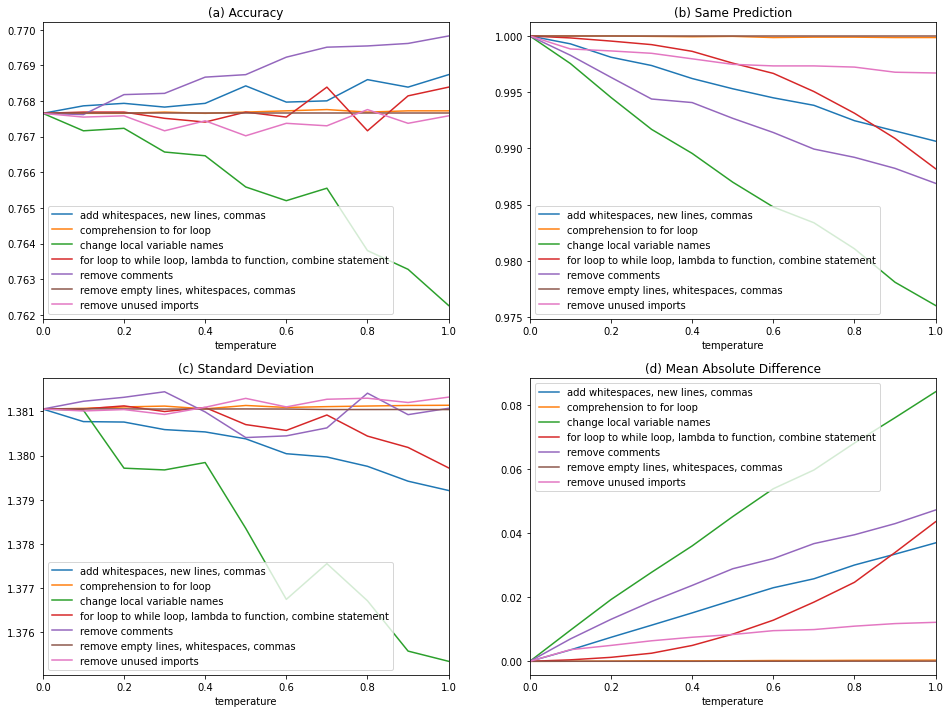

In [23]:

import string
plt.figure(figsize=(16, 12))
for i, metric in enumerate(['Accuracy', 'Same Prediction', 'Standard Deviation', 'Mean Absolute Difference']):
    plt.subplot(2,2,i+1)
#     ax = fig.add_subplot(111)
    for j, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])
        print(metric, transformation_type)
        print(x)
        print([results[transformation_type][p][metric] for p in targets])
        print(labels[transformation_type])
        print()

    plt.title(f"({string.ascii_lowercase[i]}) {metric}")
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
plt.savefig('0524_codet5')

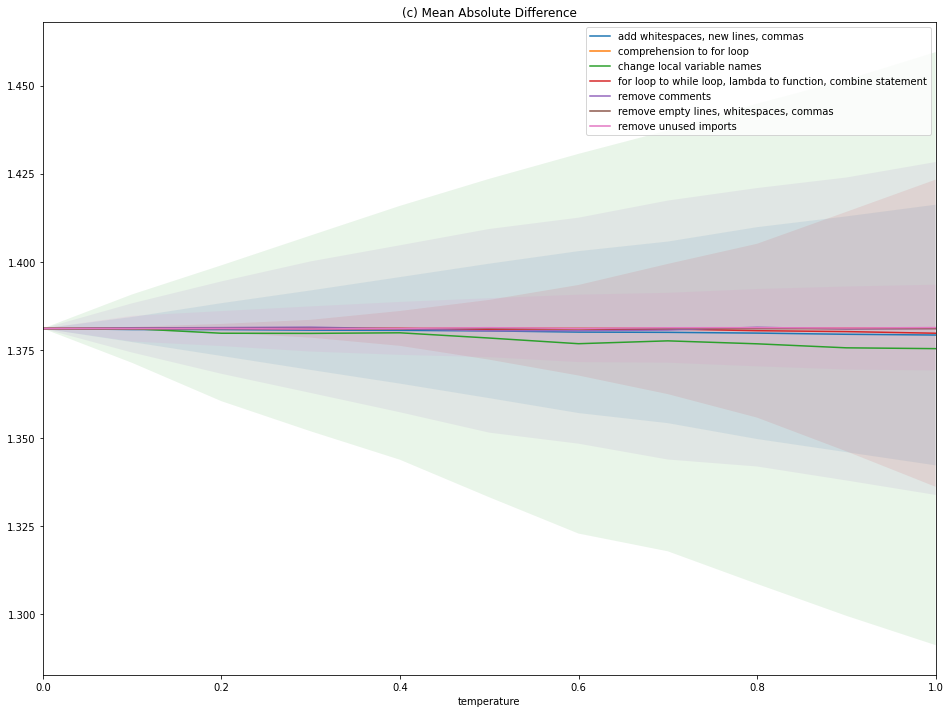

In [37]:



# for i, metric in enumerate(['Accuracy', 'Same Prediction', 'Standard Deviation', 'Mean Absolute Difference']):
#     plt.subplot(2,2,i+1)
#     ax = fig.add_subplot(111)

plt.figure(figsize=(16, 12))
for j, transformation_type in enumerate(transformation_types):
    mean = np.array([results[transformation_type][p]['Standard Deviation'] for p in targets])
    std = np.array([results[transformation_type][p]['Mean Absolute Difference'] for p in targets])
    plt.plot(
        x, 
        mean,
        label=labels[transformation_type]
    )
    plt.fill_between(x, mean-std, mean+std, alpha=.1)

plt.title(f"({string.ascii_lowercase[i]}) {metric}",)
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.savefig('0524_CodeT5_error_plot.png')
plt.show()

# ----------------------------------------------------------------------------------

In [24]:
def print_code_diff(text, code1, code2, code3, similar, show_diff=False, show_codes=True):
    print('==================================================================')
    print(text)
    print('------------------------------------------------------------------')
    if show_diff:
        print(
            "".join(
                difflib.unified_diff(code1.splitlines(1), code2.splitlines(1))
            )
        )
        print('------------------------------------------------------------------')
    if show_codes:
        print(code1)
        print('------------------------------------------------------------------')
        print(code2)
        print('------------------------------------------------------------------')
        print(code3)
        print('------------------------------------------------------------------')
    print(f'similar (original): {similar}')
    print('==================================================================')
    

In [25]:
for p in targets[1:]:
    print(f'############################## [p = {p}] #####################################')
    for key in diffs.keys():
        print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
        key = 'change_variable_names'
        item = diffs[key][p]
        size = len(diffs[key][p])
        for i in range(min(3, size)):
            code1 = data[item[i]]['original']['code1']
            code1_augmented = data[item[i]]['augmented'][p2index[p]]['code1'][key]
            similar = data[item[i]]['original']['similar']
            code2 = data[item[i]]['original']['code2']
            print('==================================================================')
            print(f"p={p}, key={key}")
            print('------------------------------------------------------------------')
            print(
                "".join(
                    difflib.unified_diff(code1.splitlines(1), code1_augmented.splitlines(1))
                )
            )
            print('------------------------------------------------------------------')
            print(code1)
            print('------------------------------------------------------------------')
            print(code1_augmented)
            print('------------------------------------------------------------------')
            print(code2)
            print('------------------------------------------------------------------')
            print(f'similar (original): {similar}')
            print(f'original: {scores[transformation_type]["0.0"][item[i]]}, transformed: {scores[transformation_type][p][item[i]]}')
            print('==================================================================')
            
#             print_code_diff(f"p={p}, key={key}", original, augmented, code2, similar, show_diff=True)
            
            time.sleep(0.5)
    

############################## [p = 0.1] #####################################
%%%%%%%%%%%%%%%%%%%%%% [key = add_whitespace,add_new_lines,add_commas] %%%%%%%%%%%%%%%%%%%%%%%%%%%


TypeError: list indices must be integers or slices, not tuple

In [ ]:
p = "1.0"
print(f'############################## [p = {p}] #####################################')
for key in diffs.keys():
    print(f'%%%%%%%%%%%%%%%%%%%%%% [key = {key}] %%%%%%%%%%%%%%%%%%%%%%%%%%%')
    item = diffs[key][p]
    size = len(diffs[key][p])
    for i in range(min(3, size)):
        original = data[item[i]]['original']['code1']
        augmented = data[item[i]]['augmented'][p2index[p]]['code1'][key]
        similar = data[item[i]]['original']['similar']
        code2 = data[item[i]]['original']['code2']
        print_code_diff(f"p={p}, key={key}", original, augmented, code2, similar, show_diff=True)
        time.sleep(0.5)

In [ ]:

import string
plt.figure(figsize=(16, 12))
for i, metric in enumerate(['Accuracy', 'Same Prediction', 'Standard Deviation', 'Mean Absolute Difference']):
    plt.subplot(2,2,i+1)
#     ax = fig.add_subplot(111)
    for j, transformation_type in enumerate(transformation_types):
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=labels[transformation_type])
        print(metric, transformation_type)
        print(x)
        print([results[transformation_type][p][metric] for p in targets])
        print(labels[transformation_type])

    plt.title(f"({string.ascii_lowercase[i]}) {metric}")
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
plt.savefig('0411_codet5')

In [38]:
1

1